In [2]:
!pip install kmodes==0.12.2
!pip install xgboost
!pip install simpledbf
!pip install geopy
!pip install xlrd
!pip install openpyxl 
!pip install shap


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np
from simpledbf import Dbf5
import geopy.distance
from geopy.distance import geodesic as GD

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

shap.initjs()
sns.set(style="white", color_codes=True)

PyTables is not installed. No support for HDF output.
/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<img src="image-20231010-120042.png" width="" align="" />

# TEM QUE VER

- [x] Distribuição dos clusters muito desigual

- [x] Cluster final vai estar muito grande por falta de caracterização (todos são muito parecidos, independente das variáveis escolhidas)

- [ ] Separar entre perguntas (hipóteses) gerais e específicas

- [x] Limpar o código

- [x] Normalizar população também?

- [x] Rodar otimizacão por score antes de excluir dados correlacionados

- [ ] Ver clusters de cidades que fazem xilogravura

- [ ] Ecoturismo no rio

- [x] Pesquisar cultura da região

- [ ] Ver se já é aplicado agricultura nas localidades

- [ ] Ver se compensa o mel com o caju

- [ ] Opções secundárias: Uva e amendoim

- [ ] Os dados de turismo da cidade não colaboram com possibilidade de ecoturismo (Piranhas e Tibiri sao nos arredores e possuem turismo)

- [x] Não se limitar apenas à uma cidade, escolher uma cidade principal e outras proximas

- [x] EXCLUIR GUAMARÉ PELO AMOR DE DEUS

# Perguntas

- [ ] Faz sentido clusterizar com dados antigos e analisar com dados atuais?

- [ ] Existe alguma IDE melhor para trabalhar?

# Importação dos dados

Foi realizada uma análise preliminar nos dados ofertados, selecionando-se apenas as variáveis mais relevantes de cada conjunto de dados segundo a equipe.

In [4]:
# Carregando os datasets municipios gerais
original_municipios_df = pd.read_csv('./Data/municipios.csv')
municipios_df = original_municipios_df.copy()
original_municipios_df

codigo_ibge                 nome  latitude  longitude  codigo_uf
0         5200050      Abadia de Goiás -16.75730   -49.4412         52
1         3100104  Abadia dos Dourados -18.48310   -47.3916         31
2         5200100            Abadiânia -16.19700   -48.7057         52
3         3100203               Abaeté -19.15510   -45.4444         31
4         1500107           Abaetetuba  -1.72183   -48.8788         15
...           ...                  ...       ...        ...        ...
5565      2933604          Xique-Xique -10.82300   -42.7245         29
5566      2517407               Zabelê  -8.07901   -37.1057         25
5567      3557154             Zacarias -21.05060   -50.0552         35
5568      2114007              Zé Doca  -3.27014   -45.6553         21
5569      4219853               Zortéa -27.45210   -51.5520         42

[5570 rows x 5 columns]

In [5]:
# Dataset de municipios apenas do semiárido
original_municipios_semiarido_df = pd.read_csv('./Data/municipios_semiarido.csv')
municipios_semiarido_df = original_municipios_semiarido_df.copy()
mask = municipios_semiarido_df['Município'].isin(['GUAMARÉ', 'PAULISTA'])
municipios_semiarido_df = municipios_semiarido_df[~mask]
original_municipios_semiarido_df

Cod IBGE  UF             Município  População Estimada - 2017
0      2700102  AL           ÁGUA BRANCA                      20467
1      2700300  AL             ARAPIRACA                     234185
2      2700706  AL               BATALHA                      18757
3      2700904  AL            BELO MONTE                       6797
4      2701209  AL           CACIMBINHAS                      10897
...        ...  ..                   ...                        ...
1257   2806008  SE          RIBEIRÓPOLIS                      18641
1258   2807006  SE  SÃO MIGUEL DO ALEIXO                       3943
1259   2807105  SE            SIMÃO DIAS                      40838
1260   2807303  SE                 TELHA                       3221
1261   2807402  SE        TOBIAS BARRETO                      52156

[1262 rows x 4 columns]

In [6]:
# Dataset de dados administrativos
original_administrativos_df = pd.read_csv('./Data/administrativos_total.csv')
administrativos_total_df = original_administrativos_df.copy()
mask = ["ANO", "IBGE7", "NOME",
        "TTREVA_EF_TOTAL", "TTREVA_EM_TOTAL", 
        "TXMOINF", "TXBRUTAMORT", "TXCOBPLP",
        "PINTERDRSAI", "REN_PIBPC_D", "REN_PVAAGR",
        "REN_PVAIND", "POP_TOT",
        ]
administrativos_total_df = administrativos_total_df[mask]

# Filtra apenas no ano de 2013
mask = administrativos_total_df['ANO'].isin([2013])
administrativos_total_df = administrativos_total_df[mask].reset_index(drop=True, inplace=False)
administrativos_total_df

ANO    IBGE7                        NOME  TTREVA_EF_TOTAL  \
0     2013  1100015  Alta Floresta D&apos;Oeste              3.4   
1     2013  1100023                   Ariquemes              3.0   
2     2013  1100031                      Cabixi              1.5   
3     2013  1100049                      Cacoal              2.4   
4     2013  1100056                  Cerejeiras              2.5   
...    ...      ...                         ...              ...   
5565  2013  5222005                  Vianópolis              2.9   
5566  2013  5222054              Vicentinópolis              4.6   
5567  2013  5222203                    Vila Boa              3.4   
5568  2013  5222302               Vila Propício              NaN   
5569  2013  5300108                    Brasília              NaN   

      TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  TXCOBPLP  PINTERDRSAI  \
0                 9.2    18.32         4.35     12.55        11.12   
1                 9.1    11.49         4.71      7.97         2.59   
2                 6.9    13.51         3.54      3.48         7.64   
3                 9.3    15.19         4.41      8.68         3.68   
4                 8.5    11.07         5.60      3.49        15.28   
...               ...      ...          ...       ...          ...   
5565             13.1    18.29         4.46      6.19        15.19   
5566             13.3    27.78         6.43      6.30         7.16   
5567             10.2    13.33         4.38      0.67         6.63   
5568              NaN     0.00         4.40      0.90         4.76   
5569              NaN    12.73         4.09     29.63         1.05   

      REN_PIBPC_D  REN_PVAAGR  REN_PVAIND  POP_TOT  
0           11.10       34.16        6.27    25728  
1           14.88        5.79       22.04   101269  
2           12.42       41.45        3.70     6495  
3           13.97       11.02       10.99    85863  
4           16.39       15.17        6.68    18041  
...           ...         ...         ...      ...  
5565        18.47       36.72       10.18    13227  
5566        27.37       44.75       14.24     7933  
5567        16.47       38.11       13.20     5246  
5568        21.92       59.97       10.22     5460  
5569        52.77        0.41        6.43  2789761  

[5570 rows x 13 columns]

In [7]:
# Dataset de dados do censo
original_censo_df = pd.read_csv('./Data/censo.csv',delimiter=';')
censo_df = original_censo_df.copy()
mask = ["ANO", 
        "Codmun7", 
        "MORT1", "MORT5", 
        "SOBRE40", "SOBRE60", "E_ANOSESTUDO", 
        "T_ANALF11A14", "T_ANALF15A17", "T_ANALF15M", "T_ANALF18A24", "T_ANALF18M", "T_ANALF25A29", "T_ANALF25M", 
        "GINI", "PIND", "PINDCRI", "PMPOB", "PMPOBCRI", "PPOB", "PPOBCRI", 
        "PREN10RICOS", "PREN20", "PREN20RICOS", "PREN40", "PREN60", "PREN80", 
        "RDPC", "RDPCT", "RIND", "RMPOB", "RPOB", 
        "THEIL", "CPR", "EMP", "P_AGRO", "P_COM", "P_CONSTR", "P_TRANSF", "P_EXTR",
        "REN0", "REN1", "RENOCUP",   
        "T_NESTUDA_NTRAB_MMEIO", "T_OCUPDESLOC_1", "T_RMAXIDOSO", "T_SLUZ",
        "T_AGUA", "AGUA_ESGOTO",
        "IDHM", "IDHM_E", "IDHM_L", "IDHM_R", "PEA18M",] 
censo_df = censo_df[mask]
censo_df = censo_df[censo_df["ANO"] == 2010]
censo_df

ANO  Codmun7  MORT1  MORT5  SOBRE40  SOBRE60  E_ANOSESTUDO  \
11130  2010  1100015  23.80  25.49    94.50    83.18          8.67   
11131  2010  1100023  19.20  20.53    96.12    87.69          9.18   
11132  2010  1100031  24.80  26.58    94.27    82.57         10.09   
11133  2010  1100049  14.30  15.38    96.41    88.56          9.74   
11134  2010  1100056  18.10  19.42    95.78    86.72         10.22   
...     ...      ...    ...    ...      ...      ...           ...   
16690  2010  5222005  14.40  17.04    93.03    82.02         10.11   
16691  2010  5222054  15.70  18.51    92.47    80.75         10.07   
16692  2010  5222203  14.50  17.09    93.02    81.98         10.49   
16693  2010  5222302  15.90  18.80    92.36    80.50          9.46   
16694  2010  5300108  14.01  15.85    94.57    86.19          9.87   

       T_ANALF11A14  T_ANALF15A17  T_ANALF15M  ...  T_OCUPDESLOC_1  \
11130          1.22          1.52       11.99  ...            1.15   
11131          1.55          1.09        7.90  ...            0.16   
11132          0.62          1.06       13.63  ...            0.65   
11133          1.01          0.80        8.29  ...            0.43   
11134          1.14          0.75       10.29  ...            0.38   
...             ...           ...         ...  ...             ...   
16690          0.66          0.74        7.97  ...            1.23   
16691          1.22          1.32       12.68  ...            1.55   
16692          3.60          1.56       15.88  ...            1.74   
16693          4.15          1.99       19.25  ...            0.20   
16694          1.10          0.80        3.47  ...            1.40   

       T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  IDHM_L  \
11130         2.20    6.02   93.69         9.31  0.641   0.526   0.763   
11131         1.40    1.42   98.54        11.40  0.702   0.600   0.806   
11132         3.10    3.64   95.49         3.31  0.650   0.559   0.757   
11133         1.84    1.11   97.96         1.85  0.718   0.620   0.821   
11134         1.43    1.15   97.53         5.34  0.692   0.602   0.799   
...            ...     ...     ...          ...    ...     ...     ...   
16690         1.33    0.17   86.89         0.38  0.712   0.622   0.818   
16691         1.25    0.30   98.60         9.04  0.684   0.562   0.804   
16692         3.81    0.22   85.25         1.98  0.647   0.534   0.818   
16693         4.48    2.41   77.94         6.63  0.634   0.505   0.802   
16694         0.71    0.09   98.13         0.72  0.824   0.742   0.873   

       IDHM_R     PEA18M  
11130   0.657     9928.0  
11131   0.716    42801.0  
11132   0.650     2648.0  
11133   0.727    37317.0  
11134   0.688     8133.0  
...       ...        ...  
16690   0.710     6201.0  
16691   0.707     3663.0  
16692   0.619     1962.0  
16693   0.629     2076.0  
16694   0.863  1361053.0  

[5565 rows x 54 columns]

# Tratamento dos dados

## Merging

In [8]:
# Precisamos converter todos os nomes para lowercase para o merge funcionar
municipios_df['nome'] = municipios_df['nome'].str.upper()
# municipios_semiarido_df['Município'] = municipios_semiarido_df['Município'].str.upper()
# administrativos_total_df['NOME'] = administrativos_total_df['NOME'].str.upper()
# censo_df['Município'] = censo_df['Município'].str.upper()

# Juntando os datasets
merged_municipios_df = pd.merge(municipios_df, municipios_semiarido_df, left_on='codigo_ibge', right_on='Cod IBGE')
merged_municipios_df = pd.merge(merged_municipios_df, administrativos_total_df, left_on='codigo_ibge', right_on='IBGE7')
merged_municipios_df = pd.merge(merged_municipios_df, censo_df, left_on='codigo_ibge', right_on='Codmun7')
merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7', 'ANO_x', 'ANO_y', 'Codmun7'], axis=1, inplace=True)
# merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7'], axis=1, inplace=True)
# merged_municipios_df['População Estimada - 2017'] = merged_municipios_df['População Estimada - 2017'].astype(int)
original_merged_df = merged_municipios_df.copy()
original_merged_df

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                 2.4              5.9    17.24         5.23  ...   
1                 4.4             16.5    55.56         5.58  ...   
2                 3.5             11.5     6.90         3.74  ...   
3                 4.3             16.0    20.58         5.18  ...   
4                 3.1             10.3    17.56         5.12  ...   
...               ...              ...      ...          ...  ...   
1255              4.8              8.3     7.75         6.31  ...   
1256              2.2             18.5     0.00         4.36  ...   
1257              4.7              6.4    21.39         4.74  ...   
1258              6.1             11.7    17.07         5.24  ...   
1259              1.1             11.3     0.00         5.07  ...   

      T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  \
0               1.61         8.04    0.64   71.44        19.88  0.628   0.612   
1               3.86         5.35    2.31   91.69         1.72  0.603   0.510   
2               2.00         8.76    9.17   77.56         9.31  0.575   0.460   
3               1.25         5.39    0.57   76.94        15.67  0.606   0.562   
4               1.09         5.80    4.42   86.17        24.11  0.601   0.517   
...              ...          ...     ...     ...          ...    ...     ...   
1255            2.99         4.09    3.87   84.19        27.22  0.587   0.479   
1256            0.17         6.97    3.21   35.07         3.05  0.544   0.443   
1257            1.87         4.08   14.26   78.04         8.72  0.600   0.498   
1258            3.18         6.14    4.86   84.97         5.68  0.585   0.479   
1259            0.00         1.80    0.68   80.03         2.66  0.623   0.587   

      IDHM_L  IDHM_R   PEA18M  
0      0.748   0.540   3481.0  
1      0.746   0.577   3455.0  
2      0.776   0.533   6123.0  
3      0.709   0.559   5181.0  
4      0.758   0.554  20898.0  
...      ...     ...      ...  
1255   0.737   0.573   3768.0  
1256   0.708   0.513   1359.0  
1257   0.764   0.569   4806.0  
1258   0.741   0.563  16888.0  
1259   0.725   0.567   1014.0  

[1260 rows x 68 columns]

## Missing values

Algumas cidades não possuem todos os dados utilizados nas análises, por isso, precisaram ser excluídas para manter o projeto data driven.

In [9]:
# df_nulls = pd.DataFrame(merged_municipios_df.isnull().sum(), columns=['Number of Missing Values'])
# df_nulls['% Missing'] = merged_municipios_df.isnull().sum() * 100 / len(merged_municipios_df)
# display(df_nulls)

# Exclui municipios com dados faltando
display(merged_municipios_df.isnull().sum())
merged_municipios_df.dropna(inplace=True)
merged_municipios_df.reset_index(drop=True, inplace=True)
merged_municipios_df

codigo_ibge    0
nome           0
latitude       0
longitude      0
codigo_uf      0
              ..
IDHM           0
IDHM_E         0
IDHM_L         0
IDHM_R         0
PEA18M         0
Length: 68, dtype: int64

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1227      2933406       WAGNER -12.28190   -41.1715         29  BA   
1228      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1229      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1230      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1231      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                 2.4              5.9    17.24         5.23  ...   
1                 4.4             16.5    55.56         5.58  ...   
2                 3.5             11.5     6.90         3.74  ...   
3                 4.3             16.0    20.58         5.18  ...   
4                 3.1             10.3    17.56         5.12  ...   
...               ...              ...      ...          ...  ...   
1227              4.8              8.3     7.75         6.31  ...   
1228              2.2             18.5     0.00         4.36  ...   
1229              4.7              6.4    21.39         4.74  ...   
1230              6.1             11.7    17.07         5.24  ...   
1231              1.1             11.3     0.00         5.07  ...   

      T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  \
0               1.61         8.04    0.64   71.44        19.88  0.628   0.612   
1               3.86         5.35    2.31   91.69         1.72  0.603   0.510   
2               2.00         8.76    9.17   77.56         9.31  0.575   0.460   
3               1.25         5.39    0.57   76.94        15.67  0.606   0.562   
4               1.09         5.80    4.42   86.17        24.11  0.601   0.517   
...              ...          ...     ...     ...          ...    ...     ...   
1227            2.99         4.09    3.87   84.19        27.22  0.587   0.479   
1228            0.17         6.97    3.21   35.07         3.05  0.544   0.443   
1229            1.87         4.08   14.26   78.04         8.72  0.600   0.498   
1230            3.18         6.14    4.86   84.97         5.68  0.585   0.479   
1231            0.00         1.80    0.68   80.03         2.66  0.623   0.587   

      IDHM_L  IDHM_R   PEA18M  
0      0.748   0.540   3481.0  
1      0.746   0.577   3455.0  
2      0.776   0.533   6123.0  
3      0.709   0.559   5181.0  
4      0.758   0.554  20898.0  
...      ...     ...      ...  
1227   0.737   0.573   3768.0  
1228   0.708   0.513   1359.0  
1229   0.764   0.569   4806.0  
1230   0.741   0.563  16888.0  
1231   0.725   0.567   1014.0  

[1232 rows x 68 columns]

## Feature scalling

Todos esses algoritmos baseados em distância são afetados pela escala das variáveis. Como temos um problema de clusterização, e nosso dados não possuim a mesma unidade de medida, é necessário realizar uma normalização dos mesmos para que o algorítmo não seja afetado pela magnitude dos valores.

In [10]:
def normalize_data(data_to_norm):
    # Normaliza os dados com z-score
    scaler_mean = data_to_norm.values.mean(axis=0)
    scaler_std = data_to_norm.values.std(axis=0)
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data_to_norm)

    # Recria o dataframe normalizado
    normalized_data = pd.DataFrame(normalized_data, columns=data_to_norm.columns)
    
    return normalized_data

In [11]:
# Separa as colunas que não serão normalizadas
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]

data_to_norm = merged_municipios_df.drop(columns=_columns, inplace=False)
data_aux = merged_municipios_df[_columns]

normalized_data = normalize_data(data_to_norm)
merged_municipios_df = data_aux.join(normalized_data)
merged_municipios_df


codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_OCUPDESLOC_1  \
0           -1.006413        -1.303810  0.086878  ...       -0.170599   
1            0.083658         1.050971  3.153936  ...        1.638504   
2           -0.406874        -0.059775 -0.740715  ...        0.142979   
3            0.029154         0.939896  0.354205  ...       -0.460055   
4           -0.624888        -0.326354  0.112490  ...       -0.588702   
...               ...              ...       ...  ...             ...   
1227         0.301672        -0.770652 -0.672683  ...        0.938984   
1228        -1.115420         1.495269 -1.292978  ...       -1.328424   
1229         0.247168        -1.192735  0.419036  ...        0.038453   
1230         1.010217        -0.015345  0.073272  ...        1.091753   
1231        -1.714958        -0.104205 -1.292978  ...       -1.465112   

      T_RMAXIDOSO    T_SLUZ    T_AGUA  AGUA_ESGOTO      IDHM    IDHM_E  \
0        1.224561 -0.521455 -0.000863     0.275422  0.929127  1.949427   
1       -0.283549 -0.270456  1.149870    -1.262085  0.288937  0.337573   
2        1.628218  0.760593  0.346914    -0.619481 -0.428075 -0.452552   
3       -0.261123 -0.531976  0.311682    -0.081015  0.365760  1.159303   
4       -0.031263  0.046674  0.836189     0.633553  0.237722  0.448190   
...           ...       ...       ...          ...       ...       ...   
1227    -0.989949 -0.035990  0.723673     0.896859 -0.120784 -0.152304   
1228     0.624681 -0.135187 -2.067637    -1.149481 -1.221910 -0.721194   
1229    -0.995556  1.525614  0.374191    -0.669433  0.212115  0.147943   
1230     0.159353  0.112806  0.767997    -0.926813 -0.171999 -0.152304   
1231    -2.273804 -0.515443  0.487275    -1.182500  0.801089  1.554365   

        IDHM_L    IDHM_R    PEA18M  
0    -0.321675 -0.592220 -0.259868  
1    -0.389909  0.379270 -0.261246  
2     0.633602 -0.776015 -0.119818  
3    -1.652238 -0.093347 -0.169752  
4     0.019495 -0.224629  0.663395  
...        ...       ...       ...  
1227 -0.696962  0.274244 -0.244655  
1228 -1.686355 -1.301145 -0.372354  
1229  0.224198  0.169218 -0.189631  
1230 -0.560494  0.011679  0.450828  
1231 -1.106366  0.116705 -0.390642  

[1232 rows x 68 columns]

In [12]:
# Plot geográfico
fig = px.scatter_mapbox(merged_municipios_df, lat='latitude', lon='longitude', 
                        hover_name='nome', size='POP_TOT', color='UF',
                        mapbox_style='stamen-toner', center=dict(lat=-12.83, lon=-36.49), zoom=4.5)
# fig.update_geos(
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
#     showland=True, landcolor="LightGreen",
#     showocean=True, oceancolor="LightBlue",
#     showlakes=False, lakecolor="Blue",
#     showrivers=True, rivercolor="Blue",
#     scope="south america",
#     mapbox_style="stamen-terrain"
# )

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Agrupamento de indivíduos

## Por população

### Otimização de clusters

> Aplicação do método do cotovelo:

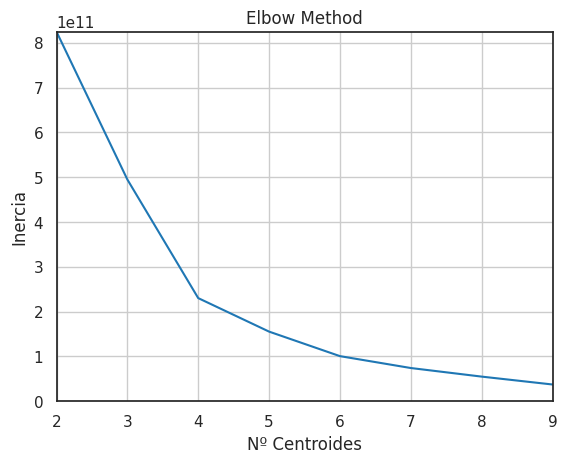

In [13]:
municipios_cluster_array = merged_municipios_df['POP_TOT'].values.reshape(-1,1)

# Determinação do número de centroides pelo método do cotovelo
centroids_max = 10
clusters_list = []
losses = []
for i in range(2,centroids_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=30)
    # kproto = KPrototypes(n_clusters=i, verbose=0, max_iter=30)
    clusters = kmeans.fit_predict(municipios_cluster_array)
    losses.append(kmeans.inertia_)

plt.plot(range(2,centroids_max), losses, color='tab:blue')
plt.xlabel('Nº Centroides')
plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.xlim([2,9])
plt.ylim([0, max(losses)])
plt.grid()

### Clusterização

In [14]:
n_clusters = 4

In [15]:
# n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(municipios_cluster_array)

centroids = kmeans.cluster_centers_
print(f'Silhouette Score: {silhouette_score(municipios_cluster_array, clusters)}')

Silhouette Score: 0.755494467136706


In [16]:
merged_municipios_df['cluster'] = clusters.astype(str)
merged_municipios_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_RMAXIDOSO    T_SLUZ  \
0           -1.006413        -1.303810  0.086878  ...     1.224561 -0.521455   
1            0.083658         1.050971  3.153936  ...    -0.283549 -0.270456   
2           -0.406874        -0.059775 -0.740715  ...     1.628218  0.760593   
3            0.029154         0.939896  0.354205  ...    -0.261123 -0.531976   
4           -0.624888        -0.326354  0.112490  ...    -0.031263  0.046674   
...               ...              ...       ...  ...          ...       ...   
1227         0.301672        -0.770652 -0.672683  ...    -0.989949 -0.035990   
1228        -1.115420         1.495269 -1.292978  ...     0.624681 -0.135187   
1229         0.247168        -1.192735  0.419036  ...    -0.995556  1.525614   
1230         1.010217        -0.015345  0.073272  ...     0.159353  0.112806   
1231        -1.714958        -0.104205 -1.292978  ...    -2.273804 -0.515443   

        T_AGUA  AGUA_ESGOTO      IDHM    IDHM_E    IDHM_L    IDHM_R    PEA18M  \
0    -0.000863     0.275422  0.929127  1.949427 -0.321675 -0.592220 -0.259868   
1     1.149870    -1.262085  0.288937  0.337573 -0.389909  0.379270 -0.261246   
2     0.346914    -0.619481 -0.428075 -0.452552  0.633602 -0.776015 -0.119818   
3     0.311682    -0.081015  0.365760  1.159303 -1.652238 -0.093347 -0.169752   
4     0.836189     0.633553  0.237722  0.448190  0.019495 -0.224629  0.663395   
...        ...          ...       ...       ...       ...       ...       ...   
1227  0.723673     0.896859 -0.120784 -0.152304 -0.696962  0.274244 -0.244655   
1228 -2.067637    -1.149481 -1.221910 -0.721194 -1.686355 -1.301145 -0.372354   
1229  0.374191    -0.669433  0.212115  0.147943  0.224198  0.169218 -0.189631   
1230  0.767997    -0.926813 -0.171999 -0.152304 -0.560494  0.011679  0.450828   
1231  0.487275    -1.182500  0.801089  1.554365 -1.106366  0.116705 -0.390642   

      cluster  
0           0  
1           0  
2           0  
3           0  
4           3  
...       ...  
1227        0  
1228        0  
1229        0  
1230        3  
1231        0  

[1232 rows x 69 columns]

In [17]:
fig = px.scatter_mapbox(
    merged_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    size='POP_TOT',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

> Através da itentificação dos clusters mais populosos, podemos reduzir o número total de municípios:

In [18]:
# Identifica clusters mais populosos
mean_pop = []
for i in range(n_clusters):
    mask = merged_municipios_df['cluster'].isin([str(i)])
    _len = merged_municipios_df[mask]['POP_TOT'].shape[0]
    _val = sum(merged_municipios_df[mask]['POP_TOT'].values)
    # Lista contendo médias de população de cada cluster
    mean_pop.append(_val / _len)

# Cria uma lista contendo os clusters mais populosos
_temp = mean_pop.copy()
_temp.sort()
highest_clusters = [str(mean_pop.index(_temp[-1])), str(mean_pop.index(_temp[-2]))]
highest_clusters
print(f'Clusters com maior população: {highest_clusters}')

# Remove clusters selecionados
mask = merged_municipios_df['cluster'].isin(highest_clusters)
lowPop_municipios_df = merged_municipios_df[~mask]
lowPop_municipios_df

Clusters com maior população: ['2', '1']


codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_RMAXIDOSO    T_SLUZ  \
0           -1.006413        -1.303810  0.086878  ...     1.224561 -0.521455   
1            0.083658         1.050971  3.153936  ...    -0.283549 -0.270456   
2           -0.406874        -0.059775 -0.740715  ...     1.628218  0.760593   
3            0.029154         0.939896  0.354205  ...    -0.261123 -0.531976   
4           -0.624888        -0.326354  0.112490  ...    -0.031263  0.046674   
...               ...              ...       ...  ...          ...       ...   
1227         0.301672        -0.770652 -0.672683  ...    -0.989949 -0.035990   
1228        -1.115420         1.495269 -1.292978  ...     0.624681 -0.135187   
1229         0.247168        -1.192735  0.419036  ...    -0.995556  1.525614   
1230         1.010217        -0.015345  0.073272  ...     0.159353  0.112806   
1231        -1.714958        -0.104205 -1.292978  ...    -2.273804 -0.515443   

        T_AGUA  AGUA_ESGOTO      IDHM    IDHM_E    IDHM_L    IDHM_R    PEA18M  \
0    -0.000863     0.275422  0.929127  1.949427 -0.321675 -0.592220 -0.259868   
1     1.149870    -1.262085  0.288937  0.337573 -0.389909  0.379270 -0.261246   
2     0.346914    -0.619481 -0.428075 -0.452552  0.633602 -0.776015 -0.119818   
3     0.311682    -0.081015  0.365760  1.159303 -1.652238 -0.093347 -0.169752   
4     0.836189     0.633553  0.237722  0.448190  0.019495 -0.224629  0.663395   
...        ...          ...       ...       ...       ...       ...       ...   
1227  0.723673     0.896859 -0.120784 -0.152304 -0.696962  0.274244 -0.244655   
1228 -2.067637    -1.149481 -1.221910 -0.721194 -1.686355 -1.301145 -0.372354   
1229  0.374191    -0.669433  0.212115  0.147943  0.224198  0.169218 -0.189631   
1230  0.767997    -0.926813 -0.171999 -0.152304 -0.560494  0.011679  0.450828   
1231  0.487275    -1.182500  0.801089  1.554365 -1.106366  0.116705 -0.390642   

      cluster  
0           0  
1           0  
2           0  
3           0  
4           3  
...       ...  
1227        0  
1228        0  
1229        0  
1230        3  
1231        0  

[1220 rows x 69 columns]

In [19]:
fig = px.scatter_mapbox(
    lowPop_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Por caracteristicas

Após a clusterização por população, realizou-se um agrupamento com base em indicadores socioeconômicos, a fim de identificar cidades com caracteristicas semelhantes àquelas ajudadas pela ONG.


### Otimização de features : Análise por score

Foi implementado um algorítmo para avaliar as melhores features na clusterização de um determinado modelo. Nele, utilizamos o score do silhouette para determinar o quanto uma variável influencia positivamente a formação dos clusters.

Silhouette score é uma métrica usada para calcular a qualidade de uma técnica de agrupamento (clustering). Seu valor varia de -1 a 1.

- 1: Significa que os clusters estão bem separados uns dos outros e claramente distintos. 

- 0: Significa que os clusters são indiferentes, ou podemos dizer que a distância entre os clusters não é significativa. 

- -1: significa que os clusters foram atribuídos de maneira errada.

O algorítmo apresenta a seguinte lógica:

1. Executar clusterização em cada um das variáveis individualmente para algum k.
2. Para cada cluster, é medido uma métrica de desempenho, como o coeficiente de silhueta implementado aqui.
3. A variável que oferece o melhor desempenho é salva numa lista.
4. O passo 2 e 3 são repetidos, porém, cada iteração as variáveis já escolhidas e salvas na lista são treinadas juntamente com as novas candidatas em busca de uma melhor performance. 
5. O critério de parada pode ser um número de variáveis desejada ou um ponto em que a métrica de desempenho não melhore significativamente. (ainda não implementado)

> Algoritmos utilizados nos processos de otimização:

In [20]:
# Função auxiliar para escolha de melhor variável
def find_best_feature(cluster_model, data_df, features_selected):
    # Setar variaveis de melhor candidato e score
    best_feature_candidate = None
    best_score = -1

    for feature_candidate in data_df.columns:
        # Verifique se a variável já foi selecionada.
        if feature_candidate not in features_selected:
            # Copia as variáveis selecionadas até agora e adiciona nova característica candidata.
            selected_features = features_selected + [feature_candidate]
            # Transformar o DataFrame em uma matriz numpy para treinar modelo
            current_data = data_df[selected_features].values

            # Executar o modelo de cluster
            clusters = cluster_model.fit_predict(current_data)
            # Calcular o índice de melhor desempenho.
            score = silhouette_score(current_data, clusters)

            # Se o valor do score for melhor do que o melhor até agora, atualize
            if score > best_score:
                best_score = score
                best_feature_candidate = feature_candidate

    return best_score, best_feature_candidate

# Plot das pontuações
def plot_scores(performance_scores):
    # Plota a curva de desempenho
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(performance_scores) + 1), performance_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de características')
    plt.ylabel('Pontuação de desempenho')
    plt.title('Curva de desempenho em relação ao número de características')
    plt.grid(True)
    plt.show()

# Função acha os melhores features de um dataset para se realizar um cluster
def cluster_feature_optimizer(cluster_model, data_df, desired_num_features=5):
    features_selected = []    # Lista com índices dos melhores features
    remaining_features = data_df.columns.tolist()    # Lista com nomes das colunas que não foram selecionadas
    performance_scores = []  # Lista dos resultados do desempenho

    while len(features_selected) < desired_num_features and remaining_features:
        best_score, best_feature_candidate = find_best_feature(cluster_model, data_df, features_selected)

        features_selected.append(best_feature_candidate)        # Salvar a melhor variável ao array
        remaining_features.remove(best_feature_candidate)       # Remove variável para
        performance_scores.append(best_score)                   # Armazena o resultado do desempenho
        print(best_feature_candidate)

    plot_scores(performance_scores)

    return features_selected

# Algoritmos implementados a partir do artigo: https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf

# Função para calcular a entropia de uma feature
def calculate_entropy(data, feature_index):
    feature_values = data[:, feature_index]
    unique_values, counts = np.unique(feature_values, return_counts=True)
    total_count = len(feature_values)
    probabilities = counts / total_count
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Função para classificar características com base na entropia
def rank_features(data):
    num_features = data.shape[1]
    feature_entropies = []

    for feature_index in range(num_features):
        entropy = calculate_entropy(data, feature_index)
        feature_entropies.append(entropy)

    # Classificação de características com base na entropia (ordem crescente)
    ranked_features = np.argsort(feature_entropies)

    return ranked_features


> Preparação do dataframe para a otimização:

In [21]:
data = lowPop_municipios_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

> Verificação inicial dos scores, considerando todas as variáveis do dataframe:

In [22]:
n_clusters = 5

In [23]:
data_array = data.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (All Features): {silhouette_score(data_array, clusters)}')

Silhouette Score (All Features): 0.09035571751489191


> Método 1: Seleção de features com base na entropia.

In [24]:
n_features = 10

In [25]:
# Gera lista de colunas com base na entropia
ranked_features = rank_features(data.values)
selected_columns = data.iloc[:, ranked_features[:n_features]]
print("Classificação de características com base na entropia: \n", selected_columns.columns)

# Clusteriza novamente considerando apenas colunas selecionadas
data_array = selected_columns.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (Selected Features): {silhouette_score(data_array, clusters)}')

Classificação de características com base na entropia: 
 Index(['GINI', 'P_EXTR', 'THEIL', 'TTREVA_EF_TOTAL', 'IDHM_L', 'EMP', 'IDHM_R',
       'IDHM', 'TTREVA_EM_TOTAL', 'MORT1'],
      dtype='object')
Silhouette Score (Selected Features): 0.16134537850786096


Inferência: O primeiro método utilizado não apresentou melhora no Silhouette Score, por isso, foi descartado.

> Método 2: Seleção de features com base no Silhouette Score (Unsupervised Feature Selection).

In [26]:
n_features = 8

In [27]:
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
#features_selected = cluster_feature_optimizer(kmeans, data, n_features)
features_selected =[
'P_EXTR',
'REN_PVAIND',
'PEA18M',
'TXCOBPLP',
'REN_PIBPC_D',
'P_TRANSF',
'RDPCT',
'RENOCUP',
]
print(f'Number of selected features: {len(features_selected)}')


Number of selected features: 8


In [28]:
data_array = data[features_selected].values

# Clusterização
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (Selected Features): {silhouette_score(data_array, clusters)}')

Silhouette Score (Selected Features): 0.275467877910803


Inferência: O modelo clusterizado a partir das features selecionadas pelo método 2 apresentaram melhoria significativa no Silhouette Score, portanto, foi utilizado no agrupamento final.

> Criação do dataframe reduzido:

In [29]:
# Gera o dataframe com as features selecionadas
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]
_columns.extend(features_selected)

reduced_lowPop_df = lowPop_municipios_df[_columns]

reduced_lowPop_df['cluster'] = clusters.astype(str)
# Dataframe apenas com variáveis selecionadas pela otimização
reduced_lowPop_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

        P_EXTR  REN_PVAIND    PEA18M  TXCOBPLP  REN_PIBPC_D  P_TRANSF  \
0    -0.317911   -0.457492 -0.259868 -0.151572    -0.689751 -0.430479   
1    -0.266632   -0.412315 -0.261246  2.118568    -0.662871 -0.694954   
2    -0.317911   -0.326481 -0.119818  0.186225    -0.639352 -0.514630   
3     2.542340    2.014766 -0.169752  0.095420    -0.175682  3.347736   
4    -0.317911    1.462489  0.663395 -0.224216     0.217430  0.045233   
...        ...         ...       ...       ...          ...       ...   
1227 -0.317911   -0.246294 -0.244655 -0.540219    -0.588953 -0.464826   
1228 -0.215352   -0.617866 -0.372354 -0.551116    -0.578873 -0.500891   
1229 -0.317911   -0.428127 -0.189631 -0.442149     0.200630 -0.533521   
1230 -0.181166   -0.466527  0.450828 -0.289596    -0.343678 -0.344610   
1231  0.701979   -0.504926 -0.390642 -0.340447    -0.249600  0.301121   

         RDPCT   RENOCUP cluster  
0    -0.656450 -0.193111       0  
1     0.240473 -0.690648       4  
2    -0.720706 -0.341828       0  
3    -0.229993  0.500656       1  
4    -0.300155  0.122269       4  
...        ...       ...     ...  
1227  0.117724 -0.074843       0  
1228 -1.140414 -1.128237       0  
1229  0.071465  0.358531       4  
1230 -0.087982  0.349763       4  
1231 -0.053252 -0.962187       0  

[1220 rows x 16 columns]

In [30]:
fig = px.scatter_mapbox(
    reduced_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    # size='POP_TOT',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Análise de correlação

Por se tratar de um longo conjunto de dados com variáveis diversas, foi preciso avaliar a existência de variáveis correlacionadas a fim de melhorar os posteriores procedimentos de otimização. Para isso, realizou-se um algoritmo que identifica exclui variáveis redundantes com base em uma tolerância positiva e negativa.

In [31]:
# Função para remoção de features correlacionadas a partir de uma tolerância
def remove_correlated(data, tolerance = 0.85):

    features = data.columns
    n_features = features.shape[0]
    correlation_matrix = data.corr().values
    correlated_features = []
    remove_features = []

    # Gera uma lista de variáveis correlacionadas 
    for row in range(n_features):
        for col in range(row, n_features):
            if(row == col):
                pass
            else:
                _val = correlation_matrix[row][col]
                if(_val >= tolerance or _val <= -tolerance):
                    correlated_features.append([features[row], features[col]])
                    # Apenas o primeiro feature do par é selecionado para remoção (pode ser alterado depois)
                    if(features[row] not in remove_features):
                        remove_features.append(features[row])

    # Remove features selecionadas
    for feature in remove_features:
        data.drop([feature], axis=1, inplace=True)

    print(f'Initial number of features: {n_features}')
    print(f'Final number of features: {data.shape[1]}')
    print('Features removed: \n', remove_features, '\n')

    return remove_features

# Plot de matrix de correlação
def plot_correlation(correlation_matrix):
    # Gera uma máscara com o triângulo superior
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("Matriz de Correlação entre Features em cada Cluster")

    plt.show()

Initial number of features: 8
Final number of features: 7
Features removed: 
 ['RDPCT'] 



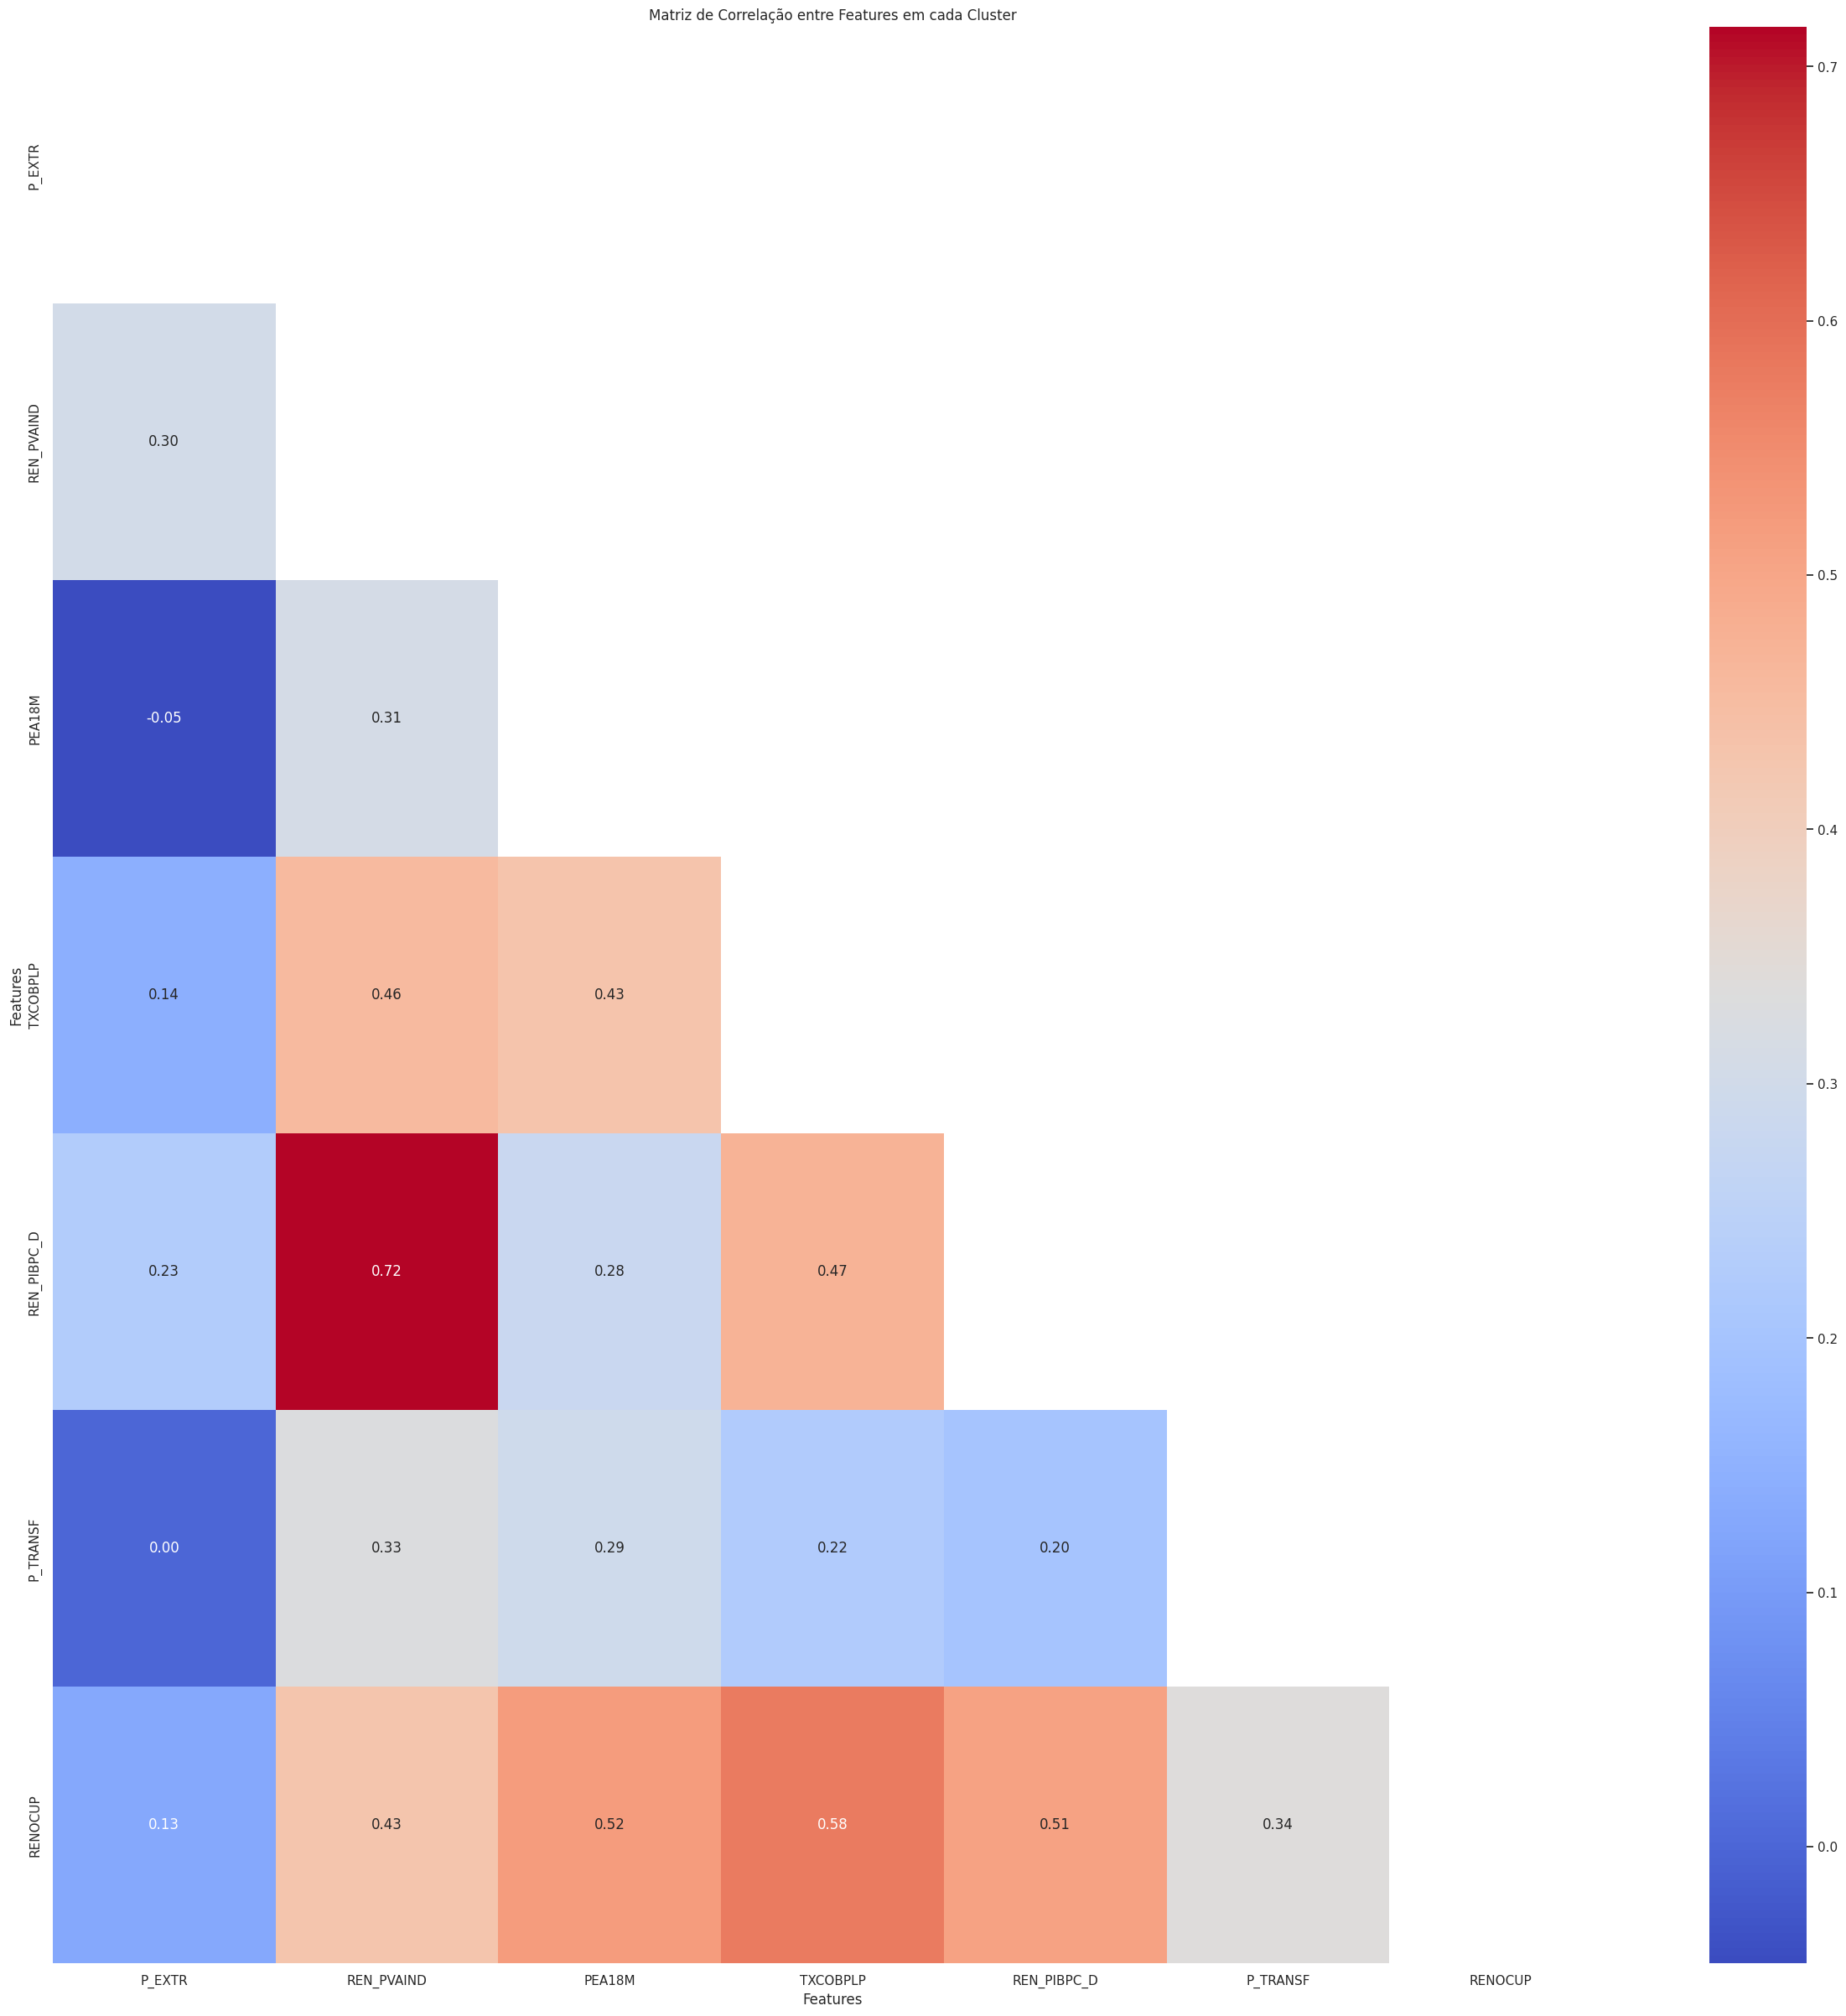

In [32]:
data = reduced_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
).copy()

remove_features = remove_correlated(data, tolerance=0.8)

plot_correlation(data.corr())

In [33]:
# Remove as features redundantes
reduced2_lowPop_df = reduced_lowPop_df.copy()
for feature in remove_features:
    reduced2_lowPop_df.drop([feature], axis=1, inplace=True)
reduced2_lowPop_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

        P_EXTR  REN_PVAIND    PEA18M  TXCOBPLP  REN_PIBPC_D  P_TRANSF  \
0    -0.317911   -0.457492 -0.259868 -0.151572    -0.689751 -0.430479   
1    -0.266632   -0.412315 -0.261246  2.118568    -0.662871 -0.694954   
2    -0.317911   -0.326481 -0.119818  0.186225    -0.639352 -0.514630   
3     2.542340    2.014766 -0.169752  0.095420    -0.175682  3.347736   
4    -0.317911    1.462489  0.663395 -0.224216     0.217430  0.045233   
...        ...         ...       ...       ...          ...       ...   
1227 -0.317911   -0.246294 -0.244655 -0.540219    -0.588953 -0.464826   
1228 -0.215352   -0.617866 -0.372354 -0.551116    -0.578873 -0.500891   
1229 -0.317911   -0.428127 -0.189631 -0.442149     0.200630 -0.533521   
1230 -0.181166   -0.466527  0.450828 -0.289596    -0.343678 -0.344610   
1231  0.701979   -0.504926 -0.390642 -0.340447    -0.249600  0.301121   

       RENOCUP cluster  
0    -0.193111       0  
1    -0.690648       4  
2    -0.341828       0  
3     0.500656       1  
4     0.122269       4  
...        ...     ...  
1227 -0.074843       0  
1228 -1.128237       0  
1229  0.358531       4  
1230  0.349763       4  
1231 -0.962187       0  

[1220 rows x 15 columns]

### Otimização de centroides

In [34]:
def find_best_k(data, min_clusters=2, max_clusters=10):
    range_n_clusters = range(min_clusters, max_clusters + 1)
    silhouette_scores = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.plot(range_n_clusters, silhouette_scores, marker='o')
    plt.title('Silhouette Score para Valores de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
    return best_n_clusters

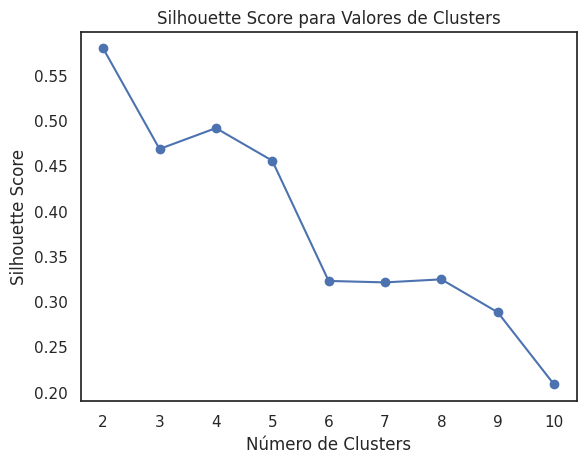

In [35]:
# Definir uma faixa de números de clusters para testar e encontrar o valor K ideal para o score
best_n_clusters = find_best_k(data=data, min_clusters=2, max_clusters=10)

O número de clusters será escolhido como 5 por ser uma boa quantidade de clusters e também conseguir distinguir eficientemente um grupo de outro. 

### Clusterização

In [36]:
n_clusters = 5

In [37]:
# Clusterização por características
data = reduced2_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100, random_state=111)
clusters = kmeans.fit_predict(data.values)
reduced2_lowPop_df['cluster'] = clusters.astype(str)

print(f'Silhouette Score: {silhouette_score(data.values, clusters)}')

Silhouette Score: 0.45982104338885793


In [38]:
fig = px.scatter_mapbox(
    reduced2_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Análise de importância com classificador

Esta análise consistiu em coverter o problema de agrupamento não supervisionado em um problema de classificação supervisionado usando um classificador. As etapas são as seguintes:

- 1: Alterar os rótulos do cluster para rótulos binários Um-vs-Todos

- 2: Treinar um classificador (RandomForest e XGBoost) para diferenciar um cluster dos demais

- 3: Imprimir as importâncias de cada variável do modelo 

In [39]:
# Essa implementacao analisa a importancia dos features para diferenciação.
def features_importance(df_original, clusters, mapa_cluster):
    # mapa_cluster = {0:1, 1:0, 2:0, 3:0}
    df = df_original.copy()
    df["cluster"] = clusters

    print(df['cluster'].value_counts())
    df['cluster'] = df['cluster'].astype(int)
    binary_cluster = df['cluster'].map(mapa_cluster)

    # Treinar classificador
    df = df.drop(columns=['cluster'])
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.values, binary_cluster.values)

    # Index sort as variáveis mais importantes
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # Salvar os features mais importantes com os nomes e pesos
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:len(df.columns)].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    return list(zip(most_important_features, most_important_weights))


def features_importance_xgboost(df_original, n_clusters, clusters):

    # Iniciar dicionário
    feature_importance_dict = {}
    # Iniciar com primeiro cluster
    cluster_to_map = 0
    # Lista com classificadores para serem plotados depois
    clf_list = []

    # Criar uma figura com subplots
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(15, 5), sharey=True)

    # Loop irá rodar para n número de clusters para se retirar a importância de cada feature para cada cluster
    while cluster_to_map < n_clusters:
        # Dicionário com os valores binários para cada cluster ex: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0}
        mapa_cluster = {cluster: 1 if cluster_to_map == cluster else 0 for cluster in range(n_clusters)}

        df = df_original.copy()
        df['cluster'] = clusters
        binary_cluster = df['cluster'].map(mapa_cluster)
        df = df.drop(columns=['cluster'])

        # Treina o modelo xgboost
        clf = xgb.XGBRegressor(objective='multi:softmax', num_class=n_clusters)
        clf.fit(df.values, binary_cluster)
        # Necessário para que apareça os nomes das features
        clf.get_booster().feature_names = df.columns.to_list()
        print("Performance do modelo xgboost: ", str(round(clf.score(df.values, binary_cluster) * 100, 2)) + "%")
        feature_importance = clf.get_booster().get_score(importance_type='weight')

        # Adicionar colunas ausentes com importância zero
        for col in df.columns:
            if col not in feature_importance:
                feature_importance[col] = 0

        feature_importance_sorted = feature_importance
        keys = list(feature_importance_sorted.keys())
        values = list(feature_importance_sorted.values())

        # Adicionar barras ao subplot correspondente
        sns.barplot(x=values, y=keys, ax=axes[cluster_to_map], palette=sns.color_palette("Set2"))
        axes[cluster_to_map].set_title(f'Cluster {cluster_to_map}')
        axes[cluster_to_map].set_xlabel('XGBoost weight')

        feature_importance_dict[str(cluster_to_map)] = feature_importance
        clf_list.append(clf)
        # Próximo cluster para ser analisado
        cluster_to_map += 1

    axes[0].set_ylabel('Feature')
    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()

    # Exibir a figura com todos os subplots
    plt.show()

    return feature_importance_dict, clf_list



In [40]:
# feature_importance, clf_list = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters)


Inferência: Os clusters foram separados em características bem definidas:  Cluster 0: Municípios com baixa renda per capta, Cluster 1: Municípios com mais alta renda per capta dentre os outros, Cluster 2: Municipios com mais alta taxa de extrativismo mineral, Cluster 3: Municípios com alta renda e baixa industrialização, Cluster 4:  Municípios com alta renda e alta industrialização. 

In [41]:
# Pairplot das variáveis 
# sns.pairplot(data=reduced2_lowPop_df, hue='cluster')
# plt.show()

## Plots

> A biblioteca SHAP fornece ferramentas úteis para avaliar a importância dos recursos de certos algoritmos “caixa preta” que têm a reputação de serem menos interpretáveis. Ele também fornece maneiras de visualizar como os recursos afetam as previsões do seu modelo.

> Fontes:
https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

In [42]:
# Treina o modelo xgboost para problema de múltipla classificação (não binária)
clf = xgb.XGBRegressor(objective='multi:softmax', num_class=n_clusters)
clf.fit(data.values, clusters)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5,
             num_parallel_tree=None, ...)

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:08:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



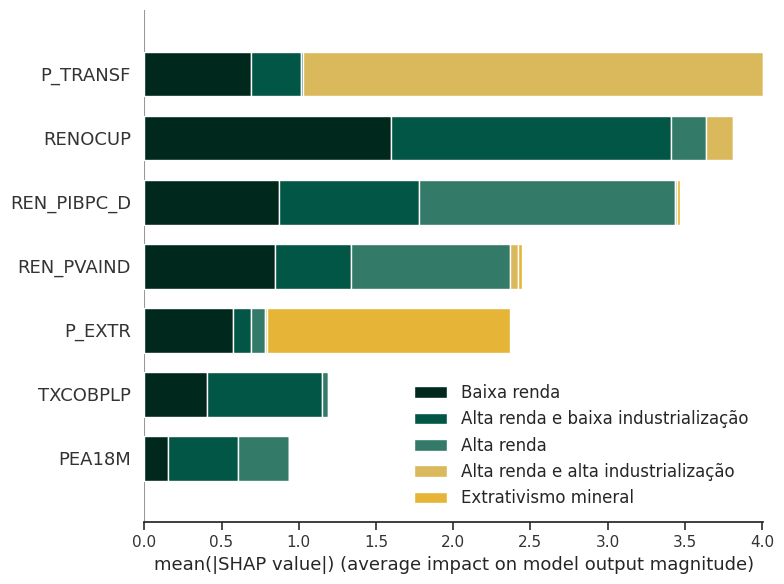

In [43]:
# Valores SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data)

# Criar mapa de cores colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
green_cmp = ListedColormap(["#00281C", "#025645", "#337B68", "#D9B95B", "#E6B437"]) # Cores BCG
class_names={0:'Baixa renda', 1:'Alta renda', 2:'Extrativismo mineral', 3:'Alta renda e baixa industrialização', 4:'Alta renda e alta industrialização'}

shap.summary_plot(shap_values, data.values, plot_type="bar", feature_names = data.columns,
                  color=green_cmp, class_names=class_names, plot_size=[8,6])

fig, ax = plt.gcf(), plt.gca()
# Modificar título, eixo x e eixo y para melhor compreesão
ax.tick_params(labelsize=14)
ax.set_xlabel("Impacto na escolha do cluster", fontsize=14)
ax.set_title('Importância de cada parâmetro', fontsize=16)

ax.tick_params(labelsize=12)
# plt.savefig('plot_feature_importance.png', transparent=True)
plt.show()

In [ ]:
# def plot_waterfall_for_cluster(df, cluster, clf):
#     explainer = shap.Explainer(clf)
#     shap_values = explainer(df)

#     plt.title(f'SHAP Values - Cluster {cluster}')
#     shap.plots.waterfall(shap_values[:, :, cluster][0])
#     # plt.show()

# for index in range(n_clusters):

#     plot_waterfall_for_cluster(data, index, clf_list[index])


In [ ]:
def plot_shap_for_cluster(df, cluster, clf):
    # explainer = shap.Explainer(clf)
    # shap_values = explainer(df)
    # Computar valores SHAP
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(df)
    plt.title(f'SHAP Values - Cluster {cluster}')

    # Crie um gráfico de beeswarm para o cluster
    # shap.plots.beeswarm(shap_values[:,:,cluster], max_display=10)  # Ajuste max_display conforme necessário
    shap.summary_plot(shap_values[1], df.values, feature_names = df.columns, plot_size=[7,4])

for index in range(n_clusters):

    plot_shap_for_cluster(data, index, clf_list[index])


/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:06:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

## Comparação com Cidades do Bem

In [ ]:
# Revertendo o dataset normalizado para seus valores iniciais
_municipios = reduced2_lowPop_df['nome']
unnormalized_df = original_merged_df[original_merged_df['nome'].isin(_municipios)]
unnormalized_df['cluster'] = reduced2_lowPop_df['cluster'].astype(str).values
unnormalized_df

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                 2.4              5.9    17.24         5.23  ...   
1                 4.4             16.5    55.56         5.58  ...   
2                 3.5             11.5     6.90         3.74  ...   
3                 4.3             16.0    20.58         5.18  ...   
4                 3.1             10.3    17.56         5.12  ...   
...               ...              ...      ...          ...  ...   
1255              4.8              8.3     7.75         6.31  ...   
1256              2.2             18.5     0.00         4.36  ...   
1257              4.7              6.4    21.39         4.74  ...   
1258              6.1             11.7    17.07         5.24  ...   
1259              1.1             11.3     0.00         5.07  ...   

      T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  IDHM_L  IDHM_R  \
0            8.04    0.64   71.44        19.88  0.628   0.612   0.748   0.540   
1            5.35    2.31   91.69         1.72  0.603   0.510   0.746   0.577   
2            8.76    9.17   77.56         9.31  0.575   0.460   0.776   0.533   
3            5.39    0.57   76.94        15.67  0.606   0.562   0.709   0.559   
4            5.80    4.42   86.17        24.11  0.601   0.517   0.758   0.554   
...           ...     ...     ...          ...    ...     ...     ...     ...   
1255         4.09    3.87   84.19        27.22  0.587   0.479   0.737   0.573   
1256         6.97    3.21   35.07         3.05  0.544   0.443   0.708   0.513   
1257         4.08   14.26   78.04         8.72  0.600   0.498   0.764   0.569   
1258         6.14    4.86   84.97         5.68  0.585   0.479   0.741   0.563   
1259         1.80    0.68   80.03         2.66  0.623   0.587   0.725   0.567   

       PEA18M  cluster  
0      3481.0        0  
1      3455.0        0  
2      6123.0        0  
3      5181.0        4  
4     20898.0        3  
...       ...      ...  
1255   3768.0        0  
1256   1359.0        0  
1257   4806.0        0  
1258  16888.0        0  
1259   1014.0        0  

[1220 rows x 69 columns]

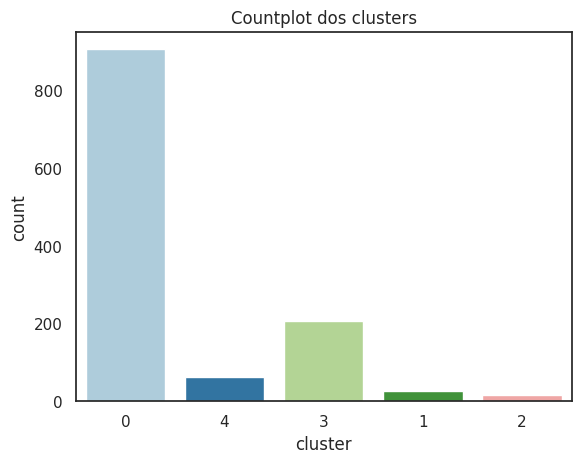

In [ ]:
# Verifica a quantidade de municípios em cada cluster
sns.countplot(data=unnormalized_df, x='cluster', palette='Paired')
plt.title('Countplot dos clusters')
plt.show()

<img src="cidades do bem.png" width="75%" align="" />

<img src="cidades do bem 2.png" width="75%" align="" />

In [ ]:
municipios_do_bem = [
                    'INAJÁ',
                    'BUÍQUE',
                    'SÃO JOSÉ DA TAPERA',
                    'MAURITI'
                    ]
                    
mask = unnormalized_df['nome'].isin(municipios_do_bem)
municipios_do_bem_df = unnormalized_df[mask]

municipios_do_bem_df[['nome', 'UF', 'cluster', 'RDPCT']]

nome  UF cluster   RDPCT
185               BUÍQUE  PE       0  183.52
486                INAJÁ  PE       0  192.01
695              MAURITI  CE       0  239.63
1067  SÃO JOSÉ DA TAPERA  AL       0  193.41

> Como todas as cidades do bem se localizam no cluster 0, podemos descartar os demais clusters para manter um número reduzido de municípios semelhantes:

In [ ]:
# Filtra os municípios pertencentes aos mesmos clusters dos municípios do bem
clusters_do_bem = municipios_do_bem_df['cluster'].unique()
mask = unnormalized_df['cluster'].isin(clusters_do_bem)
unnormalized_df = unnormalized_df[mask]
unnormalized_df.drop(columns=['cluster'], inplace=True)
unnormalized_df.reset_index(drop=True, inplace=True)
unnormalized_df

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0        2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1        2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2        2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3        2200053        ACAUÃ  -8.21954   -41.0831         22  PI   
4        2300309     ACOPIARA  -6.08911   -39.4480         23  CE   
..           ...          ...       ...        ...        ...  ..   
902      2933406       WAGNER -12.28190   -41.1715         29  BA   
903      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
904      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
905      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
906      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

     TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                2.4              5.9    17.24         5.23  ...   
1                4.4             16.5    55.56         5.58  ...   
2                3.5             11.5     6.90         3.74  ...   
3                5.2             14.6    25.00         5.37  ...   
4                3.2             13.7    17.30         6.68  ...   
..               ...              ...      ...          ...  ...   
902              4.8              8.3     7.75         6.31  ...   
903              2.2             18.5     0.00         4.36  ...   
904              4.7              6.4    21.39         4.74  ...   
905              6.1             11.7    17.07         5.24  ...   
906              1.1             11.3     0.00         5.07  ...   

     T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  \
0              1.61         8.04    0.64   71.44        19.88  0.628   0.612   
1              3.86         5.35    2.31   91.69         1.72  0.603   0.510   
2              2.00         8.76    9.17   77.56         9.31  0.575   0.460   
3              0.50         3.92    1.01   25.57        23.32  0.528   0.411   
4              1.05         7.28    1.60   61.00         9.26  0.595   0.517   
..              ...          ...     ...     ...          ...    ...     ...   
902            2.99         4.09    3.87   84.19        27.22  0.587   0.479   
903            0.17         6.97    3.21   35.07         3.05  0.544   0.443   
904            1.87         4.08   14.26   78.04         8.72  0.600   0.498   
905            3.18         6.14    4.86   84.97         5.68  0.585   0.479   
906            0.00         1.80    0.68   80.03         2.66  0.623   0.587   

     IDHM_L  IDHM_R   PEA18M  
0     0.748   0.540   3481.0  
1     0.746   0.577   3455.0  
2     0.776   0.533   6123.0  
3     0.692   0.517   2815.0  
4     0.724   0.563  19055.0  
..      ...     ...      ...  
902   0.737   0.573   3768.0  
903   0.708   0.513   1359.0  
904   0.764   0.569   4806.0  
905   0.741   0.563  16888.0  
906   0.725   0.567   1014.0  

[907 rows x 68 columns]

# Análise dos municípios

Nessa seção, buscou-se analisar minuciosamente cada aspécto dos municípios restantes, a fim de determinar qual deles são mais prioritários, segundo os pilares básicos da ONG Amigos do Bem:

<img src="amigos_do_bem_pilares.png" width="" align="" />

Além disso, verificou-se um alinhamento da ONG com os Objetivos de Desenvolvimento Sustentável (ODS's) promovidos pela Agenda 2030 das Nações Unidas, que será particularmente útil no momento de priorizar certos aspectos das ações diretas realizadas pelo grupo.

<img src="image-20231015-113433.png" width="75%" align="" />

## Indicadores de abastecimento de água

Foram avaliados alguns indicativos de abastecimento de água nos bancos de dados administrativos e censo a fim de filtrar os municípios que mais sofrem com falta de agua. Foi observado que os indicadores T_AGUA (2010), PDEFAGUA (2017) possuíam maior relação com o problema.

> Legenda:
T_AGUA : Percentual da população que vive em domicílios com água encanada.
PDEFAGUA :  Percentual de pessoas inscritas no Cadastro Único sem abastecimento de água adequado.

In [ ]:
# Carrega os dados administrativos
mask = original_administrativos_df["IBGE7"].isin(unnormalized_df["codigo_ibge"])
adm_data = original_administrativos_df[mask]  # Apenas municípios restantes

mask = adm_data["ANO"].isin([2017])
adm_data_2017 = adm_data[mask]  # Dados do ano de 2017
adm_agua = adm_data_2017[["IBGE7", "PDEFAGUA"]]
adm_agua.reset_index(drop=True, inplace=True)

# Junta os dados em um dataframe
agua_df = pd.merge(
    unnormalized_df[["codigo_ibge", "nome", "latitude", "longitude", "T_AGUA"]], adm_agua,
    left_on="codigo_ibge",
    right_on="IBGE7",
    how="inner",
)

agua_df.drop(columns=['IBGE7'], inplace=True)

agua_df


codigo_ibge         nome  latitude  longitude  T_AGUA  PDEFAGUA
0        2300101      ABAIARA  -7.34588   -39.0416   71.44     63.68
1        2900108       ABAÍRA -13.24880   -41.6619   91.69      3.94
2        2900207        ABARÉ  -8.72073   -39.1162   77.56     19.71
3        2200053        ACAUÃ  -8.21954   -41.0831   25.57     91.14
4        2300309     ACOPIARA  -6.08911   -39.4480   61.00     43.88
..           ...          ...       ...        ...     ...       ...
902      2933406       WAGNER -12.28190   -41.1715   84.19     27.25
903      2211704  WALL FERRAZ  -7.23151   -41.9050   35.07      2.15
904      2933455    WANDERLEY -12.11440   -43.8958   78.04     36.42
905      2933604  XIQUE-XIQUE -10.82300   -42.7245   84.97     38.60
906      2517407       ZABELÊ  -8.07901   -37.1057   80.03     41.36

[907 rows x 6 columns]

In [ ]:
# Cria uma coluna contendo o complemento de 100 de 'PDEFAGUA'
agua_df['PDEFAGUA2'] = 100 - agua_df['PDEFAGUA'].values
agua_df

codigo_ibge         nome  latitude  longitude  T_AGUA  PDEFAGUA  \
0        2300101      ABAIARA  -7.34588   -39.0416   71.44     63.68   
1        2900108       ABAÍRA -13.24880   -41.6619   91.69      3.94   
2        2900207        ABARÉ  -8.72073   -39.1162   77.56     19.71   
3        2200053        ACAUÃ  -8.21954   -41.0831   25.57     91.14   
4        2300309     ACOPIARA  -6.08911   -39.4480   61.00     43.88   
..           ...          ...       ...        ...     ...       ...   
902      2933406       WAGNER -12.28190   -41.1715   84.19     27.25   
903      2211704  WALL FERRAZ  -7.23151   -41.9050   35.07      2.15   
904      2933455    WANDERLEY -12.11440   -43.8958   78.04     36.42   
905      2933604  XIQUE-XIQUE -10.82300   -42.7245   84.97     38.60   
906      2517407       ZABELÊ  -8.07901   -37.1057   80.03     41.36   

     PDEFAGUA2  
0        36.32  
1        96.06  
2        80.29  
3         8.86  
4        56.12  
..         ...  
902      72.75  
903      97.85  
904      63.58  
905      61.40  
906      58.64  

[907 rows x 7 columns]

In [ ]:
# Cria um histograma com 

# Dados do histograma
x1 = agua_df['T_AGUA'].values
x2 = agua_df['PDEFAGUA'].values

# Agrupa os dados
hist_data = [x1, x2]
colors = ['darkslategray', 'lightgreen']

group_labels = ['T_AGUA 1 (2010)', 'PDEFAGUA (2017)']

# Cria um distplot
fig = ff.create_distplot(hist_data, group_labels, bin_size=5, colors=colors)
fig.update_layout(title_text='Distplot das variáveis')
# fig.update_layout(template = 'plotly_dark')

fig.show()

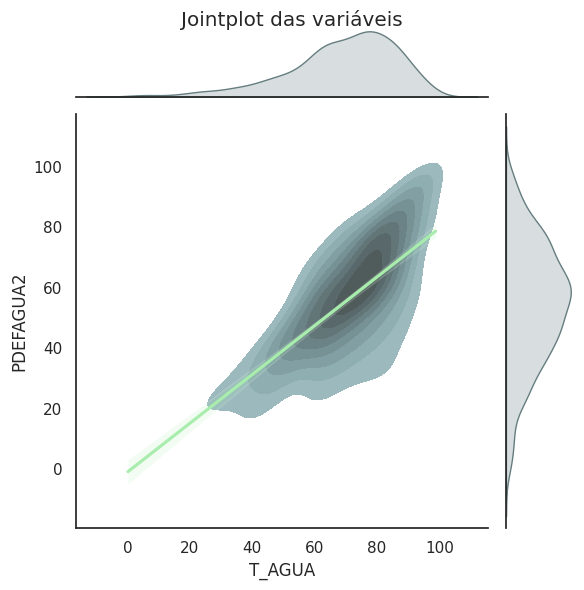

In [ ]:
# Cria um jointplot com as variáveis
p = sns.jointplot(x ='T_AGUA', y ='PDEFAGUA2', data = agua_df, kind ='kde', fill=True, color='#657d80')
sns.regplot(x="T_AGUA", y="PDEFAGUA2", data=agua_df, scatter=False, color='#a9edae')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.suptitle('Jointplot das variáveis')
plt.show()

> Percebe-se que, apesar da diferença entre os anos, possivelmente há uma relação linear entre as variáveis, conforme verificado a seguir:

In [ ]:
# Define 
data = agua_df.drop(
    [
        "codigo_ibge",
        "nome",
        "latitude",
        "longitude",
        "PDEFAGUA2",
    ],
    axis=1,
    inplace=False,
).copy()

print(f'Correlação entre as variáveis T_AGUA e PDEFAGUA: {data.corr().values[0][1]}')

Correlação entre as variáveis T_AGUA e PDEFAGUA: -0.6966455511298244


> Confirmada uma certa correlação entre as variáveis, foi decido dar prosseguimento nas análises a partir apenas do indicador 'PDEFAGUA', por se tratar de dados mais recentes:

In [ ]:
# Mapa de densidade
fig = px.density_mapbox(
    agua_df,
    lat="latitude",
    lon="longitude",
    z="PDEFAGUA",
    hover_name='nome',
    radius=10,
    color_continuous_scale='Turbo',
    mapbox_style="stamen-toner",
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5,
)

fig.update_layout(height=700, margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()


> Decidiu-se filtrar os municípios que apresentam PDEFAGUA superior à 50%:

In [ ]:
mask = agua_df['PDEFAGUA'] >= 50
agua_reduced_df = agua_df[mask]
agua_reduced_df.reset_index(drop=True, inplace=True)
agua_reduced_df

codigo_ibge                nome  latitude  longitude  T_AGUA  PDEFAGUA  \
0        2300101             ABAIARA  -7.34588   -39.0416   71.44     63.68   
1        2200053               ACAUÃ  -8.21954   -41.0831   25.57     91.14   
2        2400307      AFONSO BEZERRA  -5.49229   -36.5075   76.20     51.89   
3        2600203             AFRÂNIO  -8.51136   -41.0095   43.04     64.95   
4        2500106         ÁGUA BRANCA  -7.51144   -37.6357   62.95     53.41   
..           ...                 ...       ...        ...     ...       ...   
358      2211506         VERA MENDES  -7.59748   -41.4673   67.93     52.38   
359      2314102     VIÇOSA DO CEARÁ  -3.56670   -41.0916   65.81     66.05   
360      2517209         VIEIRÓPOLIS  -6.50684   -38.2567   69.56     54.75   
361      2211605  VILA NOVA DO PIAUÍ  -7.13272   -40.9345   21.07     98.32   
362      2505501       VISTA SERRANA  -6.73030   -37.5704   56.66     51.94   

     PDEFAGUA2  
0        36.32  
1         8.86  
2        48.11  
3        35.05  
4        46.59  
..         ...  
358      47.62  
359      33.95  
360      45.25  
361       1.68  
362      48.06  

[363 rows x 7 columns]

In [ ]:
# Plot geográfico
fig = px.scatter_mapbox(
    agua_reduced_df,
    lat="latitude",
    lon="longitude",
    color="PDEFAGUA",
    hover_name='nome',
    color_continuous_scale='Viridis',
    mapbox_style="stamen-terrain",
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5,
)


fig.update_traces(marker=dict(size=12, opacity=0.85),
                  selector=dict(mode='markers'))

fig.update_layout(height=700, margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [ ]:
# Reduz dataset completo
mask = unnormalized_df['codigo_ibge'].isin(agua_reduced_df['codigo_ibge'])
unnormalized_agua = unnormalized_df[mask]
unnormalized_agua.reset_index(drop=True,inplace=True)
unnormalized_agua

codigo_ibge                nome  latitude  longitude  codigo_uf  UF  \
0        2300101             ABAIARA  -7.34588   -39.0416         23  CE   
1        2200053               ACAUÃ  -8.21954   -41.0831         22  PI   
2        2400307      AFONSO BEZERRA  -5.49229   -36.5075         24  RN   
3        2600203             AFRÂNIO  -8.51136   -41.0095         26  PE   
4        2500106         ÁGUA BRANCA  -7.51144   -37.6357         25  PB   
..           ...                 ...       ...        ...        ...  ..   
358      2211506         VERA MENDES  -7.59748   -41.4673         22  PI   
359      2314102     VIÇOSA DO CEARÁ  -3.56670   -41.0916         23  CE   
360      2517209         VIEIRÓPOLIS  -6.50684   -38.2567         25  PB   
361      2211605  VILA NOVA DO PIAUÍ  -7.13272   -40.9345         22  PI   
362      2505501       VISTA SERRANA  -6.73030   -37.5704         25  PB   

     TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                2.4              5.9    17.24         5.23  ...   
1                5.2             14.6    25.00         5.37  ...   
2                2.2             13.4    33.06         5.99  ...   
3                1.9              8.2    20.20         4.89  ...   
4                3.9              6.3    11.36         6.27  ...   
..               ...              ...      ...          ...  ...   
358             12.3             25.0     0.00         9.27  ...   
359              3.3              9.1    11.90         5.34  ...   
360              2.8             14.6     0.00         6.12  ...   
361              2.9             10.3     0.00         4.32  ...   
362              5.3             17.4     0.00         6.80  ...   

     T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  \
0              1.61         8.04    0.64   71.44        19.88  0.628   0.612   
1              0.50         3.92    1.01   25.57        23.32  0.528   0.411   
2              1.47         7.93    0.55   76.20        18.03  0.585   0.502   
3              1.82         4.45    1.73   43.04        21.28  0.588   0.493   
4              0.77         6.50    0.56   62.95        17.55  0.572   0.484   
..              ...          ...     ...     ...          ...    ...     ...   
358            1.37        12.34    0.73   67.93         2.92  0.503   0.375   
359            1.35         6.43    1.44   65.81        22.06  0.571   0.475   
360            0.89         7.34    0.27   69.56        13.35  0.571   0.455   
361            1.11         7.07    0.85   21.07        11.31  0.565   0.471   
362            0.00         6.78    0.40   56.66        10.51  0.566   0.424   

     IDHM_L  IDHM_R   PEA18M  
0     0.748   0.540   3481.0  
1     0.692   0.517   2815.0  
2     0.713   0.560   3386.0  
3     0.761   0.542   6654.0  
4     0.712   0.542   3091.0  
..      ...     ...      ...  
358   0.685   0.494   1201.0  
359   0.753   0.521  20241.0  
360   0.762   0.537   1502.0  
361   0.685   0.559   1361.0  
362   0.773   0.554   1236.0  

[363 rows x 68 columns]

In [ ]:
qual_agua = pd.read_csv('./Data/indicadores_de_qualidade_da_agua.csv')

qual_agua

Unnamed: 0          CDESTACAO SGUF ENTIDADE       CORPODAGUA   LATITUDE  \
0              0           88045000   RS    FEPAM      Lagoa Mirim -33.499316   
1              1  88070000 ou GER68   RS    FEPAM   Arroio Del Rey -33.111140   
2              2           88150800   RS    FEPAM  Lagoa Mangueira -32.937473   
3              3           88316000   RS    FEPAM      Lagoa Mirim -32.640221   
4              4  88300500 ou GER61   RS    FEPAM     Rio Jaquarão -32.571430   
...          ...                ...  ...      ...              ...        ...   
3363        3363             MRT-01   CE   COGERH      Martinópole  -3.239127   
3364        3364             TUC-01   CE   COGERH        Tucunduba  -3.182074   
3365        3365             GAN-01   CE   COGERH         Gangorra  -3.170566   
3366        3366             DI2-01   CE   COGERH    Diamantino II  -3.154950   
3367        3367             ITA-01   CE   COGERH           Itaúna  -3.154271   

      LONGITUDE   MIN_2019   MIN_2020   MIN_2021   MED_2019   MED_2020  \
0    -53.432618  77.927723        NaN        NaN  81.201838        NaN   
1    -53.029110  51.543172        NaN        NaN  63.339936        NaN   
2    -52.693726  71.554873        NaN        NaN  73.236911        NaN   
3    -53.149368  72.920613        NaN        NaN  76.345623        NaN   
4    -53.367070  58.152945        NaN        NaN  64.180034        NaN   
...         ...        ...        ...        ...        ...        ...   
3363 -40.615051  76.308157  76.180108  81.646594  81.087824  83.223868   
3364 -40.449379  76.829506  77.175083  83.368772  84.483202  86.245055   
3365 -40.864792  78.301215  78.220457  81.463733  86.884502  87.701505   
3366 -40.363972  83.093592  83.833587  86.329544  85.917649  88.215524   
3367 -41.167488  84.765744  78.920305  78.920305  88.534082  87.254493   

       MED_2021   MAX_2019   MAX_2020   MAX_2021  
0           NaN  83.319385        NaN        NaN  
1           NaN  71.252447        NaN        NaN  
2           NaN  74.388753        NaN        NaN  
3           NaN  80.652583        NaN        NaN  
4           NaN  72.805435        NaN        NaN  
...         ...        ...        ...        ...  
3363  86.230660  86.442504  88.652841  89.071081  
3364  89.013832  88.549105  89.570863  93.143184  
3365  89.208336  91.142523  92.334734  93.840061  
3366  89.800519  88.914002  93.654403  93.654403  
3367  89.286699  91.031295  91.078043  93.679062  

[3368 rows x 16 columns]

In [ ]:
qual_agua

Unnamed: 0          CDESTACAO SGUF ENTIDADE       CORPODAGUA   LATITUDE  \
0              0           88045000   RS    FEPAM      Lagoa Mirim -33.499316   
1              1  88070000 ou GER68   RS    FEPAM   Arroio Del Rey -33.111140   
2              2           88150800   RS    FEPAM  Lagoa Mangueira -32.937473   
3              3           88316000   RS    FEPAM      Lagoa Mirim -32.640221   
4              4  88300500 ou GER61   RS    FEPAM     Rio Jaquarão -32.571430   
...          ...                ...  ...      ...              ...        ...   
3363        3363             MRT-01   CE   COGERH      Martinópole  -3.239127   
3364        3364             TUC-01   CE   COGERH        Tucunduba  -3.182074   
3365        3365             GAN-01   CE   COGERH         Gangorra  -3.170566   
3366        3366             DI2-01   CE   COGERH    Diamantino II  -3.154950   
3367        3367             ITA-01   CE   COGERH           Itaúna  -3.154271   

      LONGITUDE   MIN_2019   MIN_2020   MIN_2021   MED_2019   MED_2020  \
0    -53.432618  77.927723        NaN        NaN  81.201838        NaN   
1    -53.029110  51.543172        NaN        NaN  63.339936        NaN   
2    -52.693726  71.554873        NaN        NaN  73.236911        NaN   
3    -53.149368  72.920613        NaN        NaN  76.345623        NaN   
4    -53.367070  58.152945        NaN        NaN  64.180034        NaN   
...         ...        ...        ...        ...        ...        ...   
3363 -40.615051  76.308157  76.180108  81.646594  81.087824  83.223868   
3364 -40.449379  76.829506  77.175083  83.368772  84.483202  86.245055   
3365 -40.864792  78.301215  78.220457  81.463733  86.884502  87.701505   
3366 -40.363972  83.093592  83.833587  86.329544  85.917649  88.215524   
3367 -41.167488  84.765744  78.920305  78.920305  88.534082  87.254493   

       MED_2021   MAX_2019   MAX_2020   MAX_2021  
0           NaN  83.319385        NaN        NaN  
1           NaN  71.252447        NaN        NaN  
2           NaN  74.388753        NaN        NaN  
3           NaN  80.652583        NaN        NaN  
4           NaN  72.805435        NaN        NaN  
...         ...        ...        ...        ...  
3363  86.230660  86.442504  88.652841  89.071081  
3364  89.013832  88.549105  89.570863  93.143184  
3365  89.208336  91.142523  92.334734  93.840061  
3366  89.800519  88.914002  93.654403  93.654403  
3367  89.286699  91.031295  91.078043  93.679062  

[3368 rows x 16 columns]

In [ ]:
fig = px.scatter_mapbox(
    qual_agua,
    lat='LATITUDE',
    lon='LONGITUDE',
    hover_name='CORPODAGUA',
    color_continuous_scale='Viridis',  
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

## Indicadores de saúde

Nessa etapa buscou-se montar um panorama da saúde em cada cidade, e verificar quais cidades estão com um pior nível de atenção básica de saúde. Para tal, buscou-se avaliar cada uma das métricas e organizá-las de tal qual forma que ao incrementar sua % maior é o impacto negativo da feature para o município.  A metodologia abaixo visou somar todas as features e monitorar o seu somatório para cada município, dessa forma será possível resumir as variáveis em uma única feature e focar nas localidades com maiores scores. 

> Legenda:
TXMOINF : Número de óbitos de menores de um ano de idade, por mil nascidos vivos
TXNASC7C : 100 - Participação percentual de nascidos vivos com pelo menos sete consultas de pré natal no total de nascidos vivos
TXNBAIXOP : 100 - Participação percentual de nascidos vivos com baixo peso ao nascer no total de nascidos vivos
TXBRUTAMORT : Número total de óbitos no total da população
TXMODCNT : Número de óbitos por doenças não transmissíveis no total da população
TXMOCANMA : Número de óbitos de mulheres por câncer de mama, por 100.000 mulheres
TXMOCANPROST : Número de óbitos por câncer de próstata, por 100.000 homens
TXHIV : Razão entre o número de casos novos de AIDS (códigos B20 a B24 da CID 10) registrados no ano considerado e a população total, multiplicado por 100.000.
TXMOSUI : Número de óbitos por suicídio, por 100.000 habitantes
TXOBITMATERN : Número de óbitos maternos, por 100.000 nascidos vivos 
TXCOBPLP : 100 - Participação percentual da população coberta por planos de saúde suplementar no total da população
TXMAE10A14 : Participação percentual de meninas de 10 a 14 anos (inclusive) que tiveram filhos nascidos vivos no total de nascidos vivos.
TXMAE15A19 : Participação percentual de adolescentes de 15 a 17 anos (inclusive) que tiveram filhos nascidos vivos no total nascidos vivos.
PINTERDRSAI : Participação percentual de internações hospitalares por doenças relacionadas ao saneamento ambiental inadequado no total de internações hospitalares

In [ ]:
# Carrega os dados administrativos
mask = unnormalized_agua["codigo_ibge"]
saude_adm_df = original_administrativos_df[original_administrativos_df["IBGE7"].isin(mask)]  # Apenas municípios restantes


# Filtro do ano mais recente na base de Dados
mask = saude_adm_df["ANO"].isin([2017])
saude_adm_df = saude_adm_df[mask]  # Dados do ano de 2017
saude_adm_df

# Selecionando as features relevantes da Análise
mask = [
    "IBGE7",
    "NOME",
    "TXMOINF",
    "TXNASC7C",
    "TXNBAIXOP",
    "TXBRUTAMORT",
    "TXMODCNT",
    "TXMOCANMA",
    "TXMOCANPROST",
    "TXHIV",
    "TXMOSUI",
    "TXOBITMATERN",
    "TXCOBPLP",
    "TXMAE10A14",
    "TXMAE15A19",
    "PINTERSAP",
    "PINTERDRSAI",
    "POP_TOT",
]

saude_adm_df = saude_adm_df[mask]

# Recuperando as Coordenadas de cada cidade
saude_adm_df = saude_adm_df.merge(
    unnormalized_df[["codigo_ibge", "latitude", "longitude"]],
    left_on="IBGE7",
    right_on="codigo_ibge",
)

# Features que precisam ser ajustadas em relação a população total
for feat in ["TXMODCNT", "TXMOCANMA", "TXMOCANPROST", "TXHIV", "TXOBITMATERN"]:
    saude_adm_df[feat] = saude_adm_df[feat] / saude_adm_df["POP_TOT"]

saude_adm_df.drop(columns="POP_TOT", inplace=True)
saude_adm_df.sort_values('NOME', inplace=True)
saude_adm_df.reset_index(drop=True, inplace=True)

aux = saude_adm_df.copy()

saude_adm_df

IBGE7             NOME  TXMOINF  TXNASC7C  TXNBAIXOP  TXBRUTAMORT  \
0    2300101          Abaiara     0.00     78.29       8.53         5.26   
1    2200053            Acauã    38.10     70.48       7.62         4.45   
2    2400307   Afonso Bezerra     9.01     59.46       7.21         6.15   
3    2600203          Afrânio    23.08     75.77       6.92         6.03   
4    2300408           Aiuaba    10.87     85.87       8.15         5.53   
..       ...              ...      ...       ...        ...          ...   
358  2314102  Viçosa do Ceará    17.20     83.66       9.03         6.41   
359  2700102      Água Branca    11.83     48.22       8.58         6.25   
360  2500106      Água Branca     9.26     81.48       5.56         5.26   
361  2600500      Águas Belas    20.86     69.96       5.01         7.36   
362  2900504    Érico Cardoso    37.04     74.07       7.41         7.40   

     TXMODCNT  TXMOCANMA  TXMOCANPROST     TXHIV  TXMOSUI  TXOBITMATERN  \
0    0.020048        NaN      0.001496  0.000000      NaN      0.066798   
1    0.039154   0.000000      0.004021  0.000000      NaN      0.000000   
2    0.030234   0.000000      0.000000  0.000000      NaN           NaN   
3    0.010086   0.000528      0.000533  0.000000    10.30           NaN   
4    0.016913   0.000678      0.002026  0.000000    11.63           NaN   
..        ...        ...           ...       ...      ...           ...   
358  0.005911   0.000224      0.000331  0.000111    14.99      0.001791   
359  0.017904   0.000476      0.001916  0.000000      NaN      0.000000   
360  0.035162   0.000000      0.001903  0.000000     9.75           NaN   
361  0.010234   0.000421      0.000551  0.000054    13.93      0.003228   
362  0.038183   0.000000      0.001593  0.000000     8.92           NaN   

     TXCOBPLP  TXMAE10A14  TXMAE15A19  PINTERSAP  PINTERDRSAI  codigo_ibge  \
0        1.96        2.33       21.71      26.12         4.21      2300101   
1        0.93         NaN       20.95      37.93        10.46      2200053   
2        1.26        1.80       26.13       8.78         1.01      2400307   
3        2.45         NaN       24.23      26.14         1.15      2600203   
4        0.35         NaN       21.74      14.82         0.77      2300408   
..        ...         ...         ...        ...          ...          ...   
358      0.59        0.97       19.89      25.77         3.07      2314102   
359      0.86        0.89       23.67      26.09         6.73      2700102   
360      1.03         NaN       27.78      26.80         6.62      2500106   
361      2.08        1.53       21.97      16.52         2.07      2600500   
362      0.35        0.93       12.04      36.07         8.37      2900504   

     latitude  longitude  
0    -7.34588   -39.0416  
1    -8.21954   -41.0831  
2    -5.49229   -36.5075  
3    -8.51136   -41.0095  
4    -6.57122   -40.1178  
..        ...        ...  
358  -3.56670   -41.0916  
359  -9.26200   -37.9380  
360  -7.51144   -37.6357  
361  -9.11125   -37.1226  
362 -13.42150   -42.1352  

[363 rows x 20 columns]

> Verificou-se que algumas das features tinham muitos dadods NaN que poderiam distrocer a analise, portanto, obtou-se por removê-las:

In [ ]:
# Removendo células vazias
display(saude_adm_df.isna().sum(axis=0).sort_values(ascending=False))

saude_adm_df.drop(
    columns=[
        "TXMOSUI",
        "TXOBITMATERN",
        "TXMAE10A14",
        "TXMOCANMA",
        "TXMOCANPROST",
        "TXNBAIXOP"
    ],
    inplace=True,
)


TXMOSUI         197
TXOBITMATERN    180
TXMAE10A14       95
TXMOCANMA        65
TXMOCANPROST     29
TXNBAIXOP         6
TXCOBPLP          0
latitude          0
codigo_ibge       0
PINTERDRSAI       0
PINTERSAP         0
TXMAE15A19        0
IBGE7             0
NOME              0
TXHIV             0
TXMODCNT          0
TXBRUTAMORT       0
TXNASC7C          0
TXMOINF           0
longitude         0
dtype: int64

> Foi aplicado, então, o algoritmo de score para os dados de saúde:

In [ ]:
saude_adm_df = aux.copy()
# Calcular o complementar desses parâmetros para que quanto maior o score pior seja a situacao da cidade
for column in ["TXNASC7C", "TXCOBPLP"]:
    saude_adm_df[column] = 100 - saude_adm_df[column]

# Ignorar colunas nao numericas
ignorar = ["IBGE7", "NOME", "codigo_ibge", "latitude", "longitude"]

# Minmax scaling
def min_max_scaler(col):
    if col.name not in ignorar:
        min_ = col.min()
        max_ = col.max()
        return (col - min_) / (max_ - min_)
    return col

saude_adm_df = saude_adm_df.apply(min_max_scaler)

saude_adm_df["score"] = (
    saude_adm_df.drop(columns=["IBGE7", "NOME", "codigo_ibge", "latitude", "longitude"])
    .fillna(0)
    .sum(axis=1)
)
aux = saude_adm_df.copy()
saude_adm_df


IBGE7             NOME   TXMOINF  TXNASC7C  TXNBAIXOP  TXBRUTAMORT  \
0    2300101          Abaiara  0.000000  0.206354   0.485149     0.248609   
1    2200053            Acauã  0.393717  0.315173   0.425083     0.173469   
2    2400307   Afonso Bezerra  0.093107  0.468720   0.398020     0.331169   
3    2600203          Afrânio  0.238504  0.241466   0.378878     0.320037   
4    2300408           Aiuaba  0.112328  0.100738   0.460066     0.273655   
..       ...              ...       ...       ...        ...          ...   
358  2314102  Viçosa do Ceará  0.177741  0.131531   0.518152     0.355288   
359  2700102      Água Branca  0.122249  0.625331   0.488449     0.340445   
360  2500106      Água Branca  0.095691  0.161906   0.289109     0.248609   
361  2600500      Águas Belas  0.215563  0.322419   0.252805     0.443414   
362  2900504    Érico Cardoso  0.382763  0.265153   0.411221     0.447124   

     TXMODCNT  TXMOCANMA  TXMOCANPROST     TXHIV  ...  TXOBITMATERN  TXCOBPLP  \
0    0.059699        NaN      0.037840  0.000000  ...      0.095531  0.825497   
1    0.126464   0.000000      0.101713  0.000000  ...      0.000000  0.918626   
2    0.095291   0.000000      0.000000  0.000000  ...           NaN  0.888788   
3    0.024885   0.020861      0.013488  0.000000  ...           NaN  0.781193   
4    0.048743   0.026768      0.051242  0.000000  ...           NaN  0.971067   
..        ...        ...           ...       ...  ...           ...       ...   
358  0.010297   0.008832      0.008369  0.005406  ...      0.002562  0.949367   
359  0.052206   0.018800      0.048473  0.000000  ...      0.000000  0.924955   
360  0.112512   0.000000      0.048135  0.000000  ...           NaN  0.909584   
361  0.025406   0.016651      0.013937  0.002624  ...      0.004616  0.814647   
362  0.123070   0.000000      0.040294  0.000000  ...           NaN  0.971067   

     TXMAE10A14  TXMAE15A19  PINTERSAP  PINTERDRSAI  codigo_ibge  latitude  \
0      0.408081    0.493854   0.303058     0.095638      2300101  -7.34588   
1           NaN    0.466377   0.482732     0.237619      2200053  -8.21954   
2      0.301010    0.653651   0.039251     0.022944      2400307  -5.49229   
3           NaN    0.584960   0.303362     0.026124      2600203  -8.51136   
4           NaN    0.494939   0.131143     0.017492      2300408  -6.57122   
..          ...         ...        ...          ...          ...       ...   
358    0.133333    0.428055   0.297733     0.069741      2314102  -3.56670   
359    0.117172    0.564714   0.302602     0.152885      2700102  -9.26200   
360         NaN    0.713304   0.313403     0.150386      2500106  -7.51144   
361    0.246465    0.503254   0.157006     0.047024      2600500  -9.11125   
362    0.125253    0.144252   0.454435     0.190141      2900504 -13.42150   

     longitude     score  
0     -39.0416  3.259309  
1     -41.0831  3.640974  
2     -36.5075  3.291953  
3     -41.0095  3.091849  
4     -40.1178  2.870978  
..         ...       ...  
358   -41.0916  3.341623  
359   -37.9380  3.758281  
360   -37.6357  3.190513  
361   -37.1226  3.291355  
362   -42.1352  3.687227  

[363 rows x 21 columns]

> Por fim, filtra os municípios acima da mediana do score:

In [ ]:
# Filtra as cidades restantes
saude_df = (
    saude_adm_df[saude_adm_df["score"] > saude_adm_df["score"].median()]
    .reset_index()
    .sort_values(by="NOME", ascending=True)
)

mask = unnormalized_agua['codigo_ibge'].isin(saude_df['IBGE7'])
unnormalized_saude = unnormalized_agua[mask]
unnormalized_saude.reset_index(drop=True, inplace=True)
unnormalized_saude


codigo_ibge                nome  latitude  longitude  codigo_uf  UF  \
0        2200053               ACAUÃ  -8.21954   -41.0831         22  PI   
1        2700102         ÁGUA BRANCA  -9.26200   -37.9380         27  AL   
2        2600609           ALAGOINHA  -8.46650   -36.7788         26  PE   
3        2200251  ALAGOINHA DO PIAUÍ  -7.00039   -40.9282         22  PI   
4        2400505          ALEXANDRIA  -6.40533   -38.0142         24  RN   
..           ...                 ...       ...        ...        ...  ..   
176      2709202              TRAIPU  -9.96262   -37.0071         27  AL   
177      2313708               UMARI  -6.63893   -38.7008         23  CE   
178      2414753           VENHA-VER  -6.32016   -38.4896         24  RN   
179      2211506         VERA MENDES  -7.59748   -41.4673         22  PI   
180      2211605  VILA NOVA DO PIAUÍ  -7.13272   -40.9345         22  PI   

     TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                5.2             14.6    25.00         5.37  ...   
1                5.3             11.5    44.64         6.67  ...   
2                3.4             13.5     0.00         6.78  ...   
3                4.6             16.9     0.00         6.70  ...   
4                5.4              7.3    16.39         6.77  ...   
..               ...              ...      ...          ...  ...   
176              9.5             11.8    10.90         3.64  ...   
177              4.5             11.8    41.24         6.27  ...   
178              4.6             21.8     0.00         4.94  ...   
179             12.3             25.0     0.00         9.27  ...   
180              2.9             10.3     0.00         4.32  ...   

     T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ  T_AGUA  AGUA_ESGOTO   IDHM  IDHM_E  \
0              0.50         3.92    1.01   25.57        23.32  0.528   0.411   
1              4.53         6.58    2.88   61.78        36.29  0.549   0.432   
2              1.76         4.86    0.70   38.30        37.46  0.599   0.472   
3              0.99         4.57   13.90   47.65        10.77  0.531   0.391   
4              0.25         5.82    1.32   84.87        10.68  0.606   0.491   
..              ...          ...     ...     ...          ...    ...     ...   
176            4.80         6.46    5.10   37.18        38.60  0.532   0.395   
177            1.01         9.23    0.25   80.46        16.46  0.591   0.497   
178            1.96         7.15    1.26   94.84        18.49  0.555   0.473   
179            1.37        12.34    0.73   67.93         2.92  0.503   0.375   
180            1.11         7.07    0.85   21.07        11.31  0.565   0.471   

     IDHM_L  IDHM_R  PEA18M  
0     0.692   0.517  2815.0  
1     0.728   0.527  7581.0  
2     0.801   0.569  5594.0  
3     0.716   0.535  1928.0  
4     0.779   0.581  4614.0  
..      ...     ...     ...  
176   0.765   0.499  7630.0  
177   0.778   0.535  1878.0  
178   0.722   0.501  1369.0  
179   0.685   0.494  1201.0  
180   0.685   0.559  1361.0  

[181 rows x 68 columns]

In [ ]:
fig = px.scatter_mapbox(
    saude_df,
    lat='latitude',
    lon='longitude',
    hover_name='NOME',
    color='score', 
    size_max= 4,
    color_continuous_scale='Viridis', 
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_traces(marker=dict(size=12, opacity=0.85),
                  selector=dict(mode='markers'))

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Indicadores de renda

Nessa seção, partimos para a tarefa de reduzir mais anda o leque de cidades mais prioritárias para atividades da ONG. Como os dados mais recentes do censo acerca de rendimentos mensais são de 2010 fez-se necessário atualizar a escala da linha da pobreza para R$ de 2010. De acordo com a seguinte matéria da folha de São Paulo a linha da pobreza de 2022 está situada nos R$ 665,06, que equivalem 328,30 R$ em 2010 por meio da correção via IPCA, enquanto que a linha da pobreza em 2010 estava em 70 reais.

Optou-se por avaliar a renda domiciliar per capta excluindo os individuos de renda nula (RDPC.) para que seja uma comparacao mais adequada.

<img src="image-20231015-175229.png" width="" align="" />

https://www.gov.br/mdic/pt-br/assuntos/comercio-exterior/estatisticas/base-de-dados-bruta (deparas)

> Foi utilzado como critério de filtragem a mediana entre a linha da pobreza (R$ 328,30) e a linha da miséria (R$ 70,00): 

In [ ]:
threshold = 199 # Valor entre a linha da pobreza e alinha da miséria

mask = unnormalized_saude['RDPCT'] <= threshold
unnormalized_pobreza = unnormalized_saude[mask]
unnormalized_pobreza.reset_index(drop=True,inplace=True)

unnormalized_pobreza[["nome","RDPCT"]]

nome   RDPCT
0                          ARAIOSES  197.72
1                  BETÂNIA DO PIAUÍ  168.03
2                            BUÍQUE  183.52
3                        BURITIRAMA  191.67
4                          CACIMBAS  184.47
5                            CANAPI  188.28
6         CAPITÃO GERVÁSIO OLIVEIRA  196.67
7                 CARAÚBAS DO PIAUÍ  164.52
8                       CASSERENGUE  179.79
9              CURRAL NOVO DO PIAUÍ  192.83
10                           DAMIÃO  188.82
11                    DOM INOCÊNCIO  181.10
12                 FARTURA DO PIAUÍ  193.36
13                       GADO BRAVO  183.54
14                           GRANJA  185.68
15                         GUARIBAS  167.34
16                       IPAPORANGA  185.49
17                JACOBINA DO PIAUÍ  196.60
18                       JOÃO COSTA  197.91
19                        JOÃO DIAS  178.68
20          LAGOA DO BARRO DO PIAUÍ  160.91
21                      MATA GRANDE  192.66
22                       NORDESTINA  191.82
23              PAU D'ARCO DO PIAUÍ  172.70
24                      POÇO DANTAS  191.90
25                    QUEIMADA NOVA  172.12
26                          SALITRE  180.01
27             SANTANA DE MANGUEIRA  168.95
28  SÃO FRANCISCO DE ASSIS DO PIAUÍ  151.13
29             SÃO JOÃO DAS MISSÕES  187.99
30             SÃO MIGUEL DO TAPUIO  194.28
31                           TACIMA  197.75
32                           TRAIPU  187.73
33                        VENHA-VER  181.49
34                      VERA MENDES  182.28

In [ ]:
fig = px.scatter_mapbox(
    unnormalized_pobreza,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='RDPCT',
    color_continuous_scale='Viridis',  
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_traces(marker=dict(size=17, opacity=1),
                  selector=dict(mode='markers'))

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [ ]:
def dist_buique(cid):
    return geopy.distance.geodesic((-8.61954, -37.1606),cid).km

def dist_inaja(cid):
    return geopy.distance.geodesic((-8.90206, -37.8351),cid).km

def dist_mauriti(cid):
    return geopy.distance.geodesic((-7.38597, -38.7708),cid).km

def dist_tapera(cid):
    return geopy.distance.geodesic((-9.55768, -37.3831),cid).km


In [ ]:
# renda_minima_df["dist_buique"] = renda_minima_df["coordenadas"].apply(dist)


## Indicadores de educação

> Foram considerados índices de educação para identificar regiões com precariedade nessa área. Esses dados podem ser encontrados no dataframe administrativo e no QEdu 2020.

In [ ]:
adm_df = pd.read_csv("./Data/administrativos_total.csv")

# Coordenadas dos municípios baseado
coord = unnormalized_df[['codigo_ibge', 'latitude', 'longitude']]
coord.rename(columns={'codigo_ibge': 'IBGE7'}, inplace=True)

# Selecioanar somente municípios levantados
# mask = adm_df['IBGE7'].isin(pobreza_df['codigo_ibge'])
# adm_data = adm_df[mask]

# Utilizar dados de 2017
mask_2 = adm_df['ANO'].isin([2017])
adm_data_2017 = adm_df[mask_2]

adm_data_2017 = adm_data_2017.reset_index(drop=True)
coord = coord.reset_index(drop=True)

# Juntar coordenadas
adm_data_2017['IBGE7'] = adm_data_2017['IBGE7'].astype(str)
coord['IBGE7'] = coord['IBGE7'].astype(str)
adm_data_2017 = pd.merge(adm_data_2017, coord, on='IBGE7')


adm_data_2017

ANO DESAGREGACAO    IBGE7                        NOME  PMATPUB_EF  \
0    2017        TOTAL  2100907                    Araioses       98.68   
1    2017        TOTAL  2200053                       Acauã      100.00   
2    2017        TOTAL  2200251          Alagoinha do Piauí       92.18   
3    2017        TOTAL  2200301                  Alto Longá       95.01   
4    2017        TOTAL  2200459        Alvorada do Gurguéia      100.00   
..    ...          ...      ...                         ...         ...   
902  2017        TOTAL  3166956       Serranópolis de Minas      100.00   
903  2017        TOTAL  3170651  Vargem Grande do Rio Pardo      100.00   
904  2017        TOTAL  3170909                 Varzelândia      100.00   
905  2017        TOTAL  3171030                 Verdelândia       99.87   
906  2017        TOTAL  3171600              Virgem da Lapa       96.53   

     PMATPUB_EM  PMATPRI_EF  PMATPRI_EM  DIST_EF_TOTAL  DIST_EM_TOTAL  ...  \
0         95.87        1.32        4.13           28.6           49.4  ...   
1        100.00         NaN         NaN           24.4           22.4  ...   
2        100.00        7.82         NaN           27.4           36.0  ...   
3        100.00        4.99         NaN           20.8           37.0  ...   
4        100.00         NaN         NaN           30.6           43.2  ...   
..          ...         ...         ...            ...            ...  ...   
902      100.00         NaN         NaN            7.4           37.0  ...   
903      100.00         NaN         NaN            5.9           28.3  ...   
904      100.00         NaN         NaN            9.7           32.6  ...   
905      100.00        0.13         NaN            8.7           28.9  ...   
906      100.00        3.47         NaN            9.2           18.2  ...   

     PFLORA  PFEM_VEREADOR  PFEM_PREFEITO  PFEM_GOVERNADOR  PFEM_DEP_ESTADUAL  \
0     80.48          15.38            0.0              NaN                NaN   
1     52.40          22.22            0.0              NaN                NaN   
2     59.42          11.11            0.0              NaN                NaN   
3     87.73          22.22            0.0              NaN                NaN   
4     92.23          22.22            0.0              NaN                NaN   
..      ...            ...            ...              ...                ...   
902   56.61           0.00            0.0              NaN                NaN   
903   40.05           0.00            0.0              NaN                NaN   
904   43.92           9.09          100.0              NaN                NaN   
905   38.56           0.00            0.0              NaN                NaN   
906   42.53          11.11            0.0              NaN                NaN   

     PFEM_DEP_FEDERAL  PFEM_SENADOR  POP_TOT  latitude  longitude  
0                 NaN           NaN    46074  -2.89091   -41.9050  
1                 NaN           NaN     6966  -8.21954   -41.0831  
2                 NaN           NaN     7526  -7.00039   -40.9282  
3                 NaN           NaN    14070  -5.25634   -42.2096  
4                 NaN           NaN     5326  -8.42418   -43.7770  
..                ...           ...      ...       ...        ...  
902               NaN           NaN     4769 -15.81760   -42.8732  
903               NaN           NaN     5032 -15.39870   -42.3085  
904               NaN           NaN    19723 -15.69920   -44.0278  
905               NaN           NaN     9220 -15.58450   -43.6121  
906               NaN           NaN    14043 -16.80700   -42.3431  

[907 rows x 84 columns]

> Funções para plotar gráficos com múltiplas variáveis

In [ ]:
def make_scatter_plot(data, feature, size=''):
    if not size:
        size=feature
    
    return px.scatter_mapbox(
        data,
        lat='latitude',
        lon='longitude',
        hover_name='NOME',  
        hover_data=["NOME", feature],
        size=size,
        opacity= 0.4,
        color_continuous_scale=px.colors.sequential.Rainbow,
        size_max=10,
        mapbox_style='open-street-map',
        center=dict(lat=-12.83, lon=-36.49),
        zoom=4.5,
    )

def add_traces_scatter_plot(data, feature, size=''):
    if not size:
        size=feature
    
    trace = px.scatter_mapbox(
                data,
                lat='latitude',
                lon='longitude',
                hover_name='NOME',
                color=feature,  
                size=size,
                size_max=10,
                opacity= 0.35,
                labels={feature: feature}
            ).data[0]

    trace.name = feature

    return trace

### IDEB

> Legenda:
- IDEB_AF: Índice de Desenvolvimento da Educação Básica para os anos finais do ensino fundamental (6º ao 9º ano).
- IDEB_AI: Índice de Desenvolvimento da Educação Básica para os anos iniciais do ensino fundamental (1º ao 5º ano).

In [ ]:
print(adm_data_2017['IDEB_AI'].isnull().sum())
print(adm_data_2017['IDEB_AF'].isnull().sum())

# Estou dropando os dados sem nota, talvez fosse melhor colocar uma média para não perder os dados?
adm_data_2017 = adm_data_2017.dropna(subset=['IDEB_AI', 'IDEB_AF'])


8
21


In [ ]:
# Crie o gráfico de dispersão
fig = make_scatter_plot(adm_data_2017, 'IDEB_AI')

fig.add_trace(add_traces_scatter_plot(adm_data_2017, 'IDEB_AF'))

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# Pegar somente dados de 2017
mask = adm_df['ANO'].isin([2017])
adm_full_2017 = adm_df[mask]

# Calcular média do IDEB de todos os municípios com dados
ideb_df = adm_full_2017[['IBGE7', 'IDEB_AI', 'IDEB_AF']].copy()
ideb_df['IBGE7'] = ideb_df['IBGE7'].astype(str)
# Remover locais onde não se tem dados coletados
ideb_df.dropna(inplace=True)

ideb_ai_mean = ideb_df['IDEB_AI'].mean()
ideb_af_mean = ideb_df['IDEB_AF'].mean()

print(f"Média do brasil de IDEB 1º ao 5ºano: {ideb_ai_mean}")
print(f"Média do brasil de IDEB 6º ao 9º ano {ideb_af_mean}")

Média do brasil de IDEB 1º ao 5ºano: 5.604117210682493
Média do brasil de IDEB 6º ao 9º ano 4.374517804154303


### QEDU

In [ ]:
QEdu_2020 = pd.read_csv("./Data/QEdu_2020.csv", sep = ';')

QEdu_2020

COD Municipio  \
0                                               2507507   
1                                               2207702   
2                                               2412005   
3                                               2302800   
4                                               2110104   
...                                                 ...   
1790                                            2103505   
1791                                            2402006   
1792                                            2916401   
1793                                            2515302   
1794  Contagem de escolas conforme rede e escolas co...   

                          Cidade  COD UF   UF Total de escolas federais  \
0                    João Pessoa    25.0   PB                       4,0   
1                       Parnaíba    22.0   PI                       1,0   
2        São Gonçalo do Amarante    24.0   RN                       1,0   
3                        Canindé    23.0   CE                       1,0   
4     Santa Quitéria do Maranhão    21.0   MA                       NaN   
...                          ...     ...  ...                       ...   
1790                     Colinas    21.0   MA                       NaN   
1791                       Caicó    24.0   RN                       1,0   
1792                  Itapetinga    29.0   BA                       1,0   
1793                        Sapé    25.0   PB                       NaN   
1794                         NaN     NaN  NaN                       NaN   

     Total de escolas estaduais Total de escolas municipais  \
0                         105,0                       184,0   
1                          18,0                        90,0   
2                          11,0                        54,0   
3                           7,0                        81,0   
4                           2,0                        72,0   
...                         ...                         ...   
1790                        4,0                        54,0   
1791                       15,0                        31,0   
1792                        3,0                        42,0   
1793                        6,0                        36,0   
1794                        NaN                         NaN   

     Total de escolas privadas  Total de escolas sem creche  \
0                        174,0                        272.0   
1                         34,0                         82.0   
2                         29,0                         66.0   
3                         10,0                         32.0   
4                          5,0                         70.0   
...                        ...                          ...   
1790                       6,0                         15.0   
1791                      18,0                         39.0   
1792                      18,0                         39.0   
1793                      22,0                         23.0   
1794                       NaN                          NaN   

     Total de escolas com creche  ... Total de docentes em Subsequente  \
0                          195,0  ...                            166,0   
1                           61,0  ...                             34,0   
2                           29,0  ...                             19,0   
3                           67,0  ...                             12,0   
4                            9,0  ...                              3,0   
...                          ...  ...                              ...   
1790                        49,0  ...                              NaN   
1791                        26,0  ...                             65,0   
1792                        25,0  ...                             27,0   
1793                        41,0  ...                             15,0   
1794                         NaN  ...                              NaN   

      Total de docentes em En

In [ ]:
QEdu_2020.columns

Index(['COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
       'Total de escolas estaduais', 'Total de escolas municipais',
       'Total de escolas privadas', 'Total de escolas sem creche',
       'Total de escolas com creche',
       'Escolas que não funcionam em prédio escolar',
       'Escolas que funcionam em prédio escolar',
       'Total de escolas que não funcionam em unidade de atendimento socio educativo',
       'Total de escolas que funcionam em unidade de atendimento socio educativo',
       'Total de escolas que não funcionam em unidade prisional',
       'Total de escolas que funcionam em unidade prisional',
       'Total de escolas que não funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que não funcionam em salas de outra escola',
       'Total de escolas que funcionam em salas de outra escola',
       'Total de escolas que não funcionam em ou

In [ ]:
colunas_para_manter = [
                        'COD Municipio', 'Cidade', 'COD UF', 'UF', 
                        'Total de escolas federais', 'Total de escolas estaduais', 
                        'Total de escolas municipais', 'Total de escolas privadas',
                        'Escolas que funcionam em prédio escolar',
                        'Escolas que não funcionam em prédio escolar',
                        'Total de escolas que funcionam em unidade de atendimento socio educativo',
                        'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
                        'Total de escolas que funcionam em salas de outra escola',
                        'Total de escolas que funcionam em unidade prisional',
                        'Total de escolas que funcionam em outros locais',
                        'Total de escolas que não tem abastecimento de água da rede pública',
                        'Total de escolas que não possuem abastecimento de água',
                        'Total de escolas que não possuem energia elétrica da rede pública',
                        'Total de escolas que não possuem energia elétrica', 
                        'Total de matrículas', 'Total de docentes',
                        ]



In [ ]:
# Remover as linhas onde a coluna não pôde ser convertida para numérica (NaN)
QEdu_2020_filtrado = QEdu_2020.dropna(subset=['COD Municipio'])

QEdu_2020_filtrado = QEdu_2020_filtrado[colunas_para_manter]

# Função para trocar as vírgulas por pontos para que os dados sejam numéricos
def remover_virgulas_e_converter(valor):
    if isinstance(valor, str):
        try:
            return float(valor.replace(',', '.'))
        except ValueError:
            return valor  # Retorna o valor original em caso de erro
    else:
        return valor  # Retorna o valor original se não for uma string

# Aplicar a função às colunas selecionadas
colunas_total = [col for col in QEdu_2020_filtrado.columns if col.startswith("Total") or col.startswith("Escolas")]
QEdu_2020_filtrado[colunas_total] = QEdu_2020_filtrado[colunas_total].applymap(remover_virgulas_e_converter)

# Considerar falores nulos como 0
QEdu_2020_filtrado = QEdu_2020_filtrado.fillna(0)

QEdu_2020_filtrado.rename(columns={'COD Municipio': 'IBGE7'}, inplace=True)
QEdu_2020_filtrado['IBGE7'] = QEdu_2020_filtrado['IBGE7'].astype(str)

QEdu_2020_filtrado

IBGE7  \
0                                               2507507   
1                                               2207702   
2                                               2412005   
3                                               2302800   
4                                               2110104   
...                                                 ...   
1790                                            2103505   
1791                                            2402006   
1792                                            2916401   
1793                                            2515302   
1794  Contagem de escolas conforme rede e escolas co...   

                          Cidade  COD UF  UF  Total de escolas federais  \
0                    João Pessoa    25.0  PB                        4.0   
1                       Parnaíba    22.0  PI                        1.0   
2        São Gonçalo do Amarante    24.0  RN                        1.0   
3                        Canindé    23.0  CE                        1.0   
4     Santa Quitéria do Maranhão    21.0  MA                        0.0   
...                          ...     ...  ..                        ...   
1790                     Colinas    21.0  MA                        0.0   
1791                       Caicó    24.0  RN                        1.0   
1792                  Itapetinga    29.0  BA                        1.0   
1793                        Sapé    25.0  PB                        0.0   
1794                           0     0.0   0                        0.0   

      Total de escolas estaduais  Total de escolas municipais  \
0                          105.0                        184.0   
1                           18.0                         90.0   
2                           11.0                         54.0   
3                            7.0                         81.0   
4                            2.0                         72.0   
...                          ...                          ...   
1790                         4.0                         54.0   
1791                        15.0                         31.0   
1792                         3.0                         42.0   
1793                         6.0                         36.0   
1794                         0.0                          0.0   

      Total de escolas privadas  Escolas que funcionam em prédio escolar  \
0                         174.0                                    466.0   
1                          34.0                                    140.0   
2                          29.0                                     94.0   
3                          10.0                                     97.0   
4                           5.0                                     74.0   
...                         ...                                      ...   
1790                        6.0                                     61.0   
1791                       18.0                                     63.0   
1792                       18.0                                     61.0   
1793                       22.0                                     64.0   
1794                        0.0                                      0.0   

      Escolas que não funcionam em prédio escolar  ...  \
0                                             1.0  ...   
1                                             3.0  ...   
2                                             1.0  ...   
3                                             2.0  ...   
4                                             5.0  ...   
...                                           ...  ...   
1790                                          3.0  ...   
1791                                          2.0  ...   
1792                                          3.0  ...   
1793                                          0.0  ...   
1794                                          0.0  ...   

      Total de escolas que funcionam em galpão / 

> Os dados como estão são difíceis de interpretar, já que um local pode ter índices mais baixos simplesmente por ter um maior número de escolas. Portanto, serão criadas novas colunas com variações dos parâmetros anteriores. Foi decidido utilizar:
- Total de escolas (quantidade de opções para os jovens).
- Proporção entre a quantidade de docentes e o número de alunos matriculados (verificar se os professores estão sobrecarregados).
- Taxa de escolas sem prédio escolar, energia elétrica ou abastecimento de água (avaliar a qualidade das instalações estudantis).

In [ ]:
# Total de escolas
QEdu_2020_filtrado['TOTESCOLAS'] = (QEdu_2020_filtrado['Total de escolas federais'] + 
                                       QEdu_2020_filtrado['Total de escolas estaduais'] + 
                                       QEdu_2020_filtrado['Total de escolas municipais']+
                                       QEdu_2020_filtrado['Total de escolas privadas'])

# Proporção docentes-matriculados
QEdu_2020_filtrado['DOCMATR'] = QEdu_2020_filtrado['Total de docentes'] / QEdu_2020_filtrado['Total de matrículas']
# Taxa de escolas sem energia elétrica
QEdu_2020_filtrado['TXSENER'] = QEdu_2020_filtrado['Total de escolas que não possuem energia elétrica'] / QEdu_2020_filtrado['TOTESCOLAS']
# Taxa de escolas sem 
QEdu_2020_filtrado['TXSAGUA'] = QEdu_2020_filtrado['Total de escolas que não possuem abastecimento de água'] / QEdu_2020_filtrado['TOTESCOLAS']
# Taxa de escolas sem prédio escolar
QEdu_2020_filtrado['TXSPREDIO'] = QEdu_2020_filtrado['Escolas que não funcionam em prédio escolar']  / QEdu_2020_filtrado['TOTESCOLAS']

# Dropar colunas altigas desnecessárias agora
QEdu_2020_filtrado = QEdu_2020_filtrado.drop(columns=['Total de escolas federais', 'Total de escolas estaduais', 
                        'Total de escolas municipais', 'Total de escolas privadas',
                        'Escolas que funcionam em prédio escolar',
                        'Escolas que não funcionam em prédio escolar',
                        'Total de escolas que funcionam em unidade de atendimento socio educativo',
                        'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
                        'Total de escolas que funcionam em salas de outra escola',
                        'Total de escolas que funcionam em unidade prisional',
                        'Total de escolas que funcionam em outros locais',
                        'Total de escolas que não tem abastecimento de água da rede pública',
                        'Total de escolas que não possuem abastecimento de água',
                        'Total de escolas que não possuem energia elétrica da rede pública',
                        'Total de escolas que não possuem energia elétrica', 
                        'Total de matrículas', 'Total de docentes'])

QEdu_2020_filtrado

IBGE7  \
0                                               2507507   
1                                               2207702   
2                                               2412005   
3                                               2302800   
4                                               2110104   
...                                                 ...   
1790                                            2103505   
1791                                            2402006   
1792                                            2916401   
1793                                            2515302   
1794  Contagem de escolas conforme rede e escolas co...   

                          Cidade  COD UF  UF  TOTESCOLAS   DOCMATR  TXSENER  \
0                    João Pessoa    25.0  PB       467.0  0.044834      0.0   
1                       Parnaíba    22.0  PI       143.0  0.043468      0.0   
2        São Gonçalo do Amarante    24.0  RN        95.0  0.042697      0.0   
3                        Canindé    23.0  CE        99.0  0.037701      0.0   
4     Santa Quitéria do Maranhão    21.0  MA        79.0  0.064553      0.0   
...                          ...     ...  ..         ...       ...      ...   
1790                     Colinas    21.0  MA        64.0  0.034231      0.0   
1791                       Caicó    24.0  RN        65.0  0.052341      0.0   
1792                  Itapetinga    29.0  BA        64.0  0.037755      0.0   
1793                        Sapé    25.0  PB        64.0  0.043072      0.0   
1794                           0     0.0   0         0.0       NaN      NaN   

       TXSAGUA  TXSPREDIO  
0     0.000000   0.002141  
1     0.076923   0.020979  
2     0.000000   0.010526  
3     0.030303   0.020202  
4     0.265823   0.063291  
...        ...        ...  
1790  0.031250   0.046875  
1791  0.015385   0.030769  
1792  0.093750   0.046875  
1793  0.015625   0.000000  
1794       NaN        NaN  

[1795 rows x 9 columns]

### Clusterização

> A mesma metodologia abordada anteriormente foi aplicada novamente nesta seção. O objetivo é identificar municípios com bons índices educacionais e aqueles onde um déficit nessa área possa ser observado. Estas últimas regiões são as que mais necessitam da assistência da ONG.

In [ ]:
adm_data_2017

ANO DESAGREGACAO    IBGE7                        NOME  PMATPUB_EF  \
0    2017        TOTAL  2100907                    Araioses       98.68   
1    2017        TOTAL  2200053                       Acauã      100.00   
2    2017        TOTAL  2200251          Alagoinha do Piauí       92.18   
3    2017        TOTAL  2200301                  Alto Longá       95.01   
4    2017        TOTAL  2200459        Alvorada do Gurguéia      100.00   
..    ...          ...      ...                         ...         ...   
902  2017        TOTAL  3166956       Serranópolis de Minas      100.00   
903  2017        TOTAL  3170651  Vargem Grande do Rio Pardo      100.00   
904  2017        TOTAL  3170909                 Varzelândia      100.00   
905  2017        TOTAL  3171030                 Verdelândia       99.87   
906  2017        TOTAL  3171600              Virgem da Lapa       96.53   

     PMATPUB_EM  PMATPRI_EF  PMATPRI_EM  DIST_EF_TOTAL  DIST_EM_TOTAL  ...  \
0         95.87        1.32        4.13           28.6           49.4  ...   
1        100.00         NaN         NaN           24.4           22.4  ...   
2        100.00        7.82         NaN           27.4           36.0  ...   
3        100.00        4.99         NaN           20.8           37.0  ...   
4        100.00         NaN         NaN           30.6           43.2  ...   
..          ...         ...         ...            ...            ...  ...   
902      100.00         NaN         NaN            7.4           37.0  ...   
903      100.00         NaN         NaN            5.9           28.3  ...   
904      100.00         NaN         NaN            9.7           32.6  ...   
905      100.00        0.13         NaN            8.7           28.9  ...   
906      100.00        3.47         NaN            9.2           18.2  ...   

     PFLORA  PFEM_VEREADOR  PFEM_PREFEITO  PFEM_GOVERNADOR  PFEM_DEP_ESTADUAL  \
0     80.48          15.38            0.0              NaN                NaN   
1     52.40          22.22            0.0              NaN                NaN   
2     59.42          11.11            0.0              NaN                NaN   
3     87.73          22.22            0.0              NaN                NaN   
4     92.23          22.22            0.0              NaN                NaN   
..      ...            ...            ...              ...                ...   
902   56.61           0.00            0.0              NaN                NaN   
903   40.05           0.00            0.0              NaN                NaN   
904   43.92           9.09          100.0              NaN                NaN   
905   38.56           0.00            0.0              NaN                NaN   
906   42.53          11.11            0.0              NaN                NaN   

     PFEM_DEP_FEDERAL  PFEM_SENADOR  POP_TOT  latitude  longitude  
0                 NaN           NaN    46074  -2.89091   -41.9050  
1                 NaN           NaN     6966  -8.21954   -41.0831  
2                 NaN           NaN     7526  -7.00039   -40.9282  
3                 NaN           NaN    14070  -5.25634   -42.2096  
4                 NaN           NaN     5326  -8.42418   -43.7770  
..                ...           ...      ...       ...        ...  
902               NaN           NaN     4769 -15.81760   -42.8732  
903               NaN           NaN     5032 -15.39870   -42.3085  
904               NaN           NaN    19723 -15.69920   -44.0278  
905               NaN           NaN     9220 -15.58450   -43.6121  
906               NaN           NaN    14043 -16.80700   -42.3431  

[881 rows x 84 columns]

In [ ]:
# Juntar dados educacionais administrativos com o QEdu

educacao_df = pd.merge(adm_data_2017[['IBGE7', 'IDEB_AI', 'IDEB_AF', 'latitude', 'longitude']], QEdu_2020_filtrado, on='IBGE7')
edu_train_cluster = educacao_df.drop(columns=['Cidade', 'UF', 'IBGE7', 'COD UF', 'latitude', 'longitude', 'IBGE7'])

edu_train_cluster = normalize_data(edu_train_cluster)

edu_train_cluster

IDEB_AI   IDEB_AF  TOTESCOLAS   DOCMATR   TXSENER   TXSAGUA  TXSPREDIO
0   -0.979213 -0.523500    3.862908  1.347692 -0.208547 -0.190901   0.555936
1    0.695058  0.549372   -0.661958 -0.598540 -0.208547 -0.320850  -0.311556
2   -0.532741  0.281154   -0.855881  0.638715 -0.208547 -0.320850  -0.311556
3    0.248585 -0.389391    0.566220  0.592064 -0.208547 -0.320850  -0.311556
4   -1.648922  0.415263   -0.791240  2.491483 -0.208547 -0.320850  -0.311556
..        ...       ...         ...       ...       ...       ...        ...
814 -0.755977 -0.925827   -0.597317  0.361250 -0.208547 -0.320850   2.842960
815 -0.421123 -0.389391   -0.403394 -1.555818 -0.208547 -0.320850  -0.311556
816  1.141530 -1.059936   -0.597317  0.065151 -0.208547 -0.320850  -0.311556
817  0.471821 -0.523500    0.501579 -0.465825  0.916137 -0.320850   0.927718
818 -0.309505 -1.059936    7.159596 -0.589375 -0.208547 -0.320850   3.396806

[819 rows x 7 columns]

In [ ]:
remove_correlated(edu_train_cluster)

Initial number of features: 7
Final number of features: 7
Features removed: 
 [] 



[]

In [ ]:
# Municípios perdidos por não conterem dados (linhas com código ibge iguais de adm)
# mask = adm_data_2017_filtrado['IBGE7'].astype(str).isin(QEdu_2020['COD Municipio'])
# rows_not_in_QEdu_2020 = adm_data_2017_filtrado[~mask]
# rows_not_in_QEdu_2020

> Econtrar número ótimo de clusters

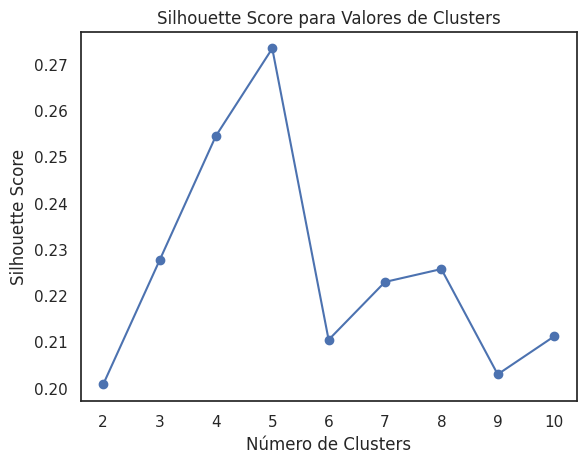

Melhor número de clusters: 5


In [ ]:
best_k = find_best_k(edu_train_cluster)

print(f"Melhor número de clusters: {best_k}")

In [ ]:
model = KMeans(n_clusters=best_k, verbose=0, init='k-means++', max_iter=100, random_state=111)

# from sklearn.cluster import AgglomerativeClustering
# Criar o modelo Agglomerative Clustering
# model = AgglomerativeClustering(n_clusters=4)


#best_features_edu = cluster_feature_optimizer(model, edu_train_cluster, 8)
best_features_edu = [
'TXSENER',
'TXSPREDIO',
'TXSAGUA',
'TOTESCOLAS',
'IDEB_AI',
'IDEB_AF',
'DOCMATR']

> Devido ao desempenho insatisfatório em todas as variáveis juntas, foi removido a razão de docentes/matriculados, pois não demonstrou bom desempenho. Além disso, foi eliminado o número total de escolas, uma vez que este atributo não apresentou capacidade significativa de distinção para o processo de clusterização.

In [ ]:
best_features_edu.remove('TOTESCOLAS')
best_features_edu.remove('DOCMATR')

clusters = model.fit_predict(edu_train_cluster[best_features_edu])

print(f'Silhouette Score: {silhouette_score(edu_train_cluster[best_features_edu], clusters)}')

Silhouette Score: 0.4235326752457546


In [ ]:
educacao_df['cluster'] = clusters.astype(str)

fig = px.scatter_mapbox(
    educacao_df,
    lat='latitude',
    lon='longitude',
    hover_name='Cidade',
    # size='POP_TOT',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Performance do modelo xgboost:  100.0%
Performance do modelo xgboost:  100.0%
Performance do modelo xgboost:  100.0%
Performance do modelo xgboost:  100.0%
Performance do modelo xgboost:  100.0%


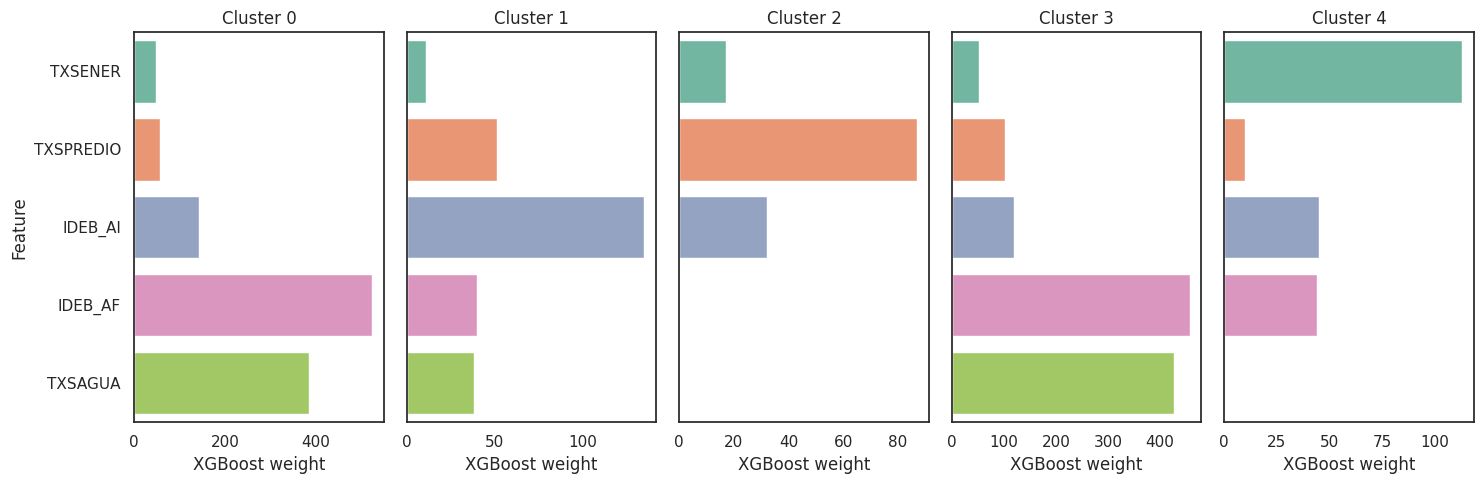

In [ ]:
feature_importance, clf_list = features_importance_xgboost(edu_train_cluster[best_features_edu],  n_clusters=best_k, clusters=clusters)

In [ ]:
# Pairplot das variáveis 
# sns.pairplot(data=educacao_df, hue='cluster')
# plt.show()

In [ ]:
# Treina o modelo xgboost para problema de múltipla classificação (não binária)
clf = xgb.XGBRegressor(objective='multi:softmax', num_class=n_clusters)
clf.fit(edu_train_cluster[best_features_edu].values, clusters)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5,
             num_parallel_tree=None, ...)

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:03:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



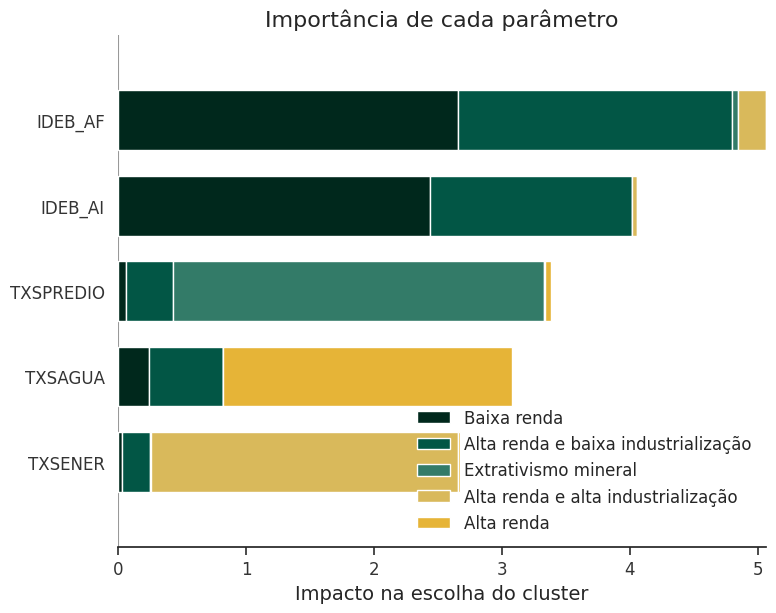

In [ ]:
# Valores SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(edu_train_cluster[best_features_edu])

# Criar mapa de cores colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
green_cmp = ListedColormap(["#00281C", "#025645", "#337B68", "#D9B95B", "#E6B437"]) # Cores BCG
class_names={0:'Baixa renda', 1:'Alta renda', 2:'Extrativismo mineral', 3:'Alta renda e baixa industrialização', 4:'Alta renda e alta industrialização'}

shap.summary_plot(shap_values, edu_train_cluster[best_features_edu].values, plot_type="bar", feature_names = edu_train_cluster[best_features_edu].columns,
                  color=green_cmp, class_names=class_names, plot_size=[8,6], show=False)

fig, ax = plt.gcf(), plt.gca()
# Modificar título, eixo x e eixo y para melhor compreesão
ax.tick_params(labelsize=14)
ax.set_xlabel("Impacto na escolha do cluster", fontsize=14)
ax.set_title('Importância de cada parâmetro', fontsize=16)

ax.tick_params(labelsize=12)
#plt.savefig('plot_feature_importance_edu.png', transparent=True)
plt.show()

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:03:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



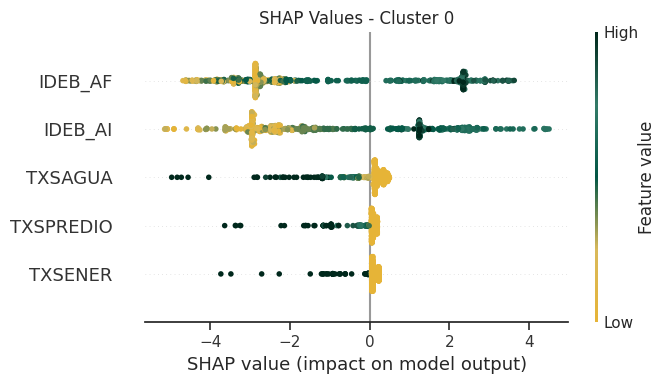

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:03:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



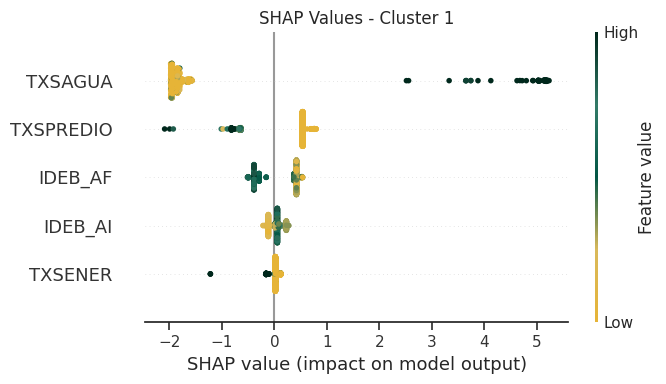

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:03:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



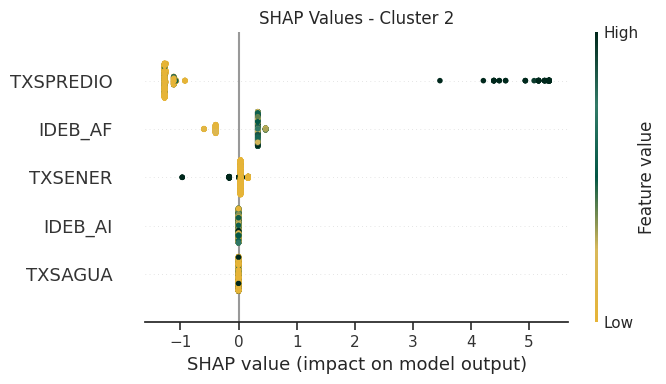

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:03:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



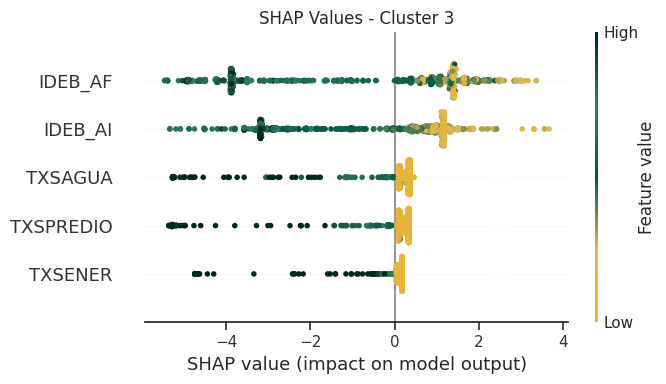

/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[19:03:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



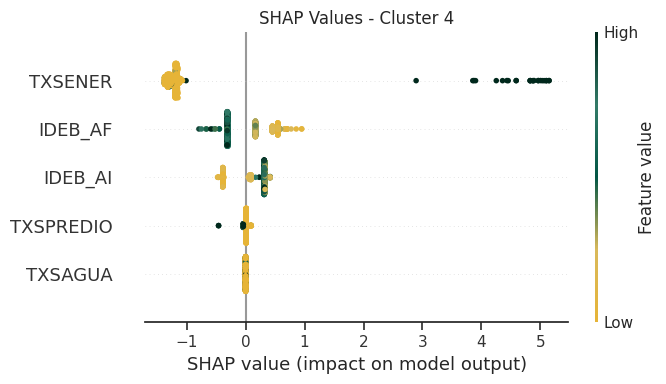

In [ ]:
for index in range(n_clusters):

    plot_shap_for_cluster(edu_train_cluster[best_features_edu], index, clf_list[index])


> Inferência: Cluster 4 são municípios com alta taxa de escolas sem energia elétrica. Cluster 2 muitos não tem prédio escolar. Cluster 1 temos lugares sem abastecimento de água. Cluster 1 e cluster 3 apresentaram boas notas de IDEB, logo, são lugares com melhor qualidade de ensino.

In [ ]:
edu_merge = educacao_df.copy()
edu_merge.rename(columns={'IBGE7': 'codigo_ibge'}, inplace=True)
edu_merge = edu_merge[['codigo_ibge', 'cluster', 'IDEB_AI', 'IDEB_AF']]
edu_merge['codigo_ibge'] = edu_merge['codigo_ibge'].astype(str)

In [ ]:
unnormalized_pobreza

codigo_ibge                             nome  latitude  longitude  \
0       2100907                         ARAIOSES  -2.89091   -41.9050   
1       2201739                 BETÂNIA DO PIAUÍ  -8.14376   -40.7989   
2       2602803                           BUÍQUE  -8.61954   -37.1606   
3       2904753                       BURITIRAMA -10.71710   -43.6302   
4       2503555                         CACIMBAS  -7.20721   -37.0604   
5       2701605                           CANAPI  -9.11932   -37.5967   
6       2202455        CAPITÃO GERVÁSIO OLIVEIRA  -8.49655   -41.8140   
7       2202539                CARAÚBAS DO PIAUÍ  -3.47525   -41.8425   
8       2504157                      CASSERENGUE  -6.77954   -35.8179   
9       2203271             CURRAL NOVO DO PIAUÍ  -7.83130   -40.8957   
10      2505352                           DAMIÃO  -6.63161   -35.9101   
11      2203453                    DOM INOCÊNCIO  -9.00516   -41.9697   
12      2203750                 FARTURA DO PIAUÍ  -9.48342   -42.7912   
13      2506251                       GADO BRAVO  -7.58279   -35.7899   
14      2304707                           GRANJA  -3.12788   -40.8372   
15      2204550                         GUARIBAS  -9.38647   -43.6943   
16      2305654                       IPAPORANGA  -4.89764   -40.7537   
17      2205151                JACOBINA DO PIAUÍ  -7.93063   -41.2075   
18      2205359                       JOÃO COSTA  -8.50736   -42.4264   
19      2405900                        JOÃO DIAS  -6.27215   -37.7885   
20      2205565          LAGOA DO BARRO DO PIAUÍ  -8.47673   -41.5342   
21      2705002                      MATA GRANDE  -9.11824   -37.7323   
22      2922656                       NORDESTINA -10.81920   -39.4297   
23      2207793              PAU D'ARCO DO PIAUÍ  -5.26072   -42.3908   
24      2512036                      POÇO DANTAS  -6.39876   -38.4909   
25      2208650                    QUEIMADA NOVA  -8.57064   -41.4106   
26      2311959                          SALITRE  -7.28398   -40.4500   
27      2513505             SANTANA DE MANGUEIRA  -7.54705   -38.3236   
28      2209658  SÃO FRANCISCO DE ASSIS DO PIAUÍ  -8.23599   -41.6873   
29      3162450             SÃO JOÃO DAS MISSÕES -14.88590   -44.0922   
30      2210409             SÃO MIGUEL DO TAPUIO  -5.49729   -41.3165   
31      2516409                           TACIMA  -6.48759   -35.6367   
32      2709202                           TRAIPU  -9.96262   -37.0071   
33      2414753                        VENHA-VER  -6.32016   -38.4896   
34      2211506                      VERA MENDES  -7.59748   -41.4673   

    codigo_uf  UF  TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  \
0          21  MA             11.5             18.2    15.44         3.66   
1          22  PI              4.8             10.1    33.33         5.09   
2          26  PE              5.0             10.7     9.39         5.41   
3          29  BA              3.7              8.7    38.02         3.41   
4          25  PB              5.4             12.3    37.59         5.83   
5          27  AL              8.2             10.1    15.38         4.36   
6          22  PI              5.4             28.1    74.07         7.55   
7          22  PI              3.3             16.2     0.00         4.23   
8          25  PB              7.9             16.2    12.35         4.79   
9          22  PI              5.2             20.9    12.82         2.98   
10         25  PB              1.8             19.1     0.00         3.89   
11         22  PI              4.2             10.3    11.49         5.34   
12         22  PI             11.8             14.7    24.39         3.48   
13         25  PB              6.0             24.6     0.00         6.02   
14         23  CE              2.7             11.2    29.24         4.77   
15         22  PI              6.4             15.1    14.93         2.24   
16         23  CE              4.1             13.3    29.85      

In [ ]:
unnormalized_edu = unnormalized_pobreza.copy()

unnormalized_edu['codigo_ibge'] = unnormalized_edu['codigo_ibge'].astype(str)

unnormalized_edu = pd.merge(unnormalized_edu, edu_merge, on='codigo_ibge',  how='left')

not_merged = unnormalized_edu[unnormalized_edu['IDEB_AI'].isnull()]
# Cidades foram descartadas por não apresentarem dados de educação
print(not_merged)

unnormalized_edu

   codigo_ibge                  nome  latitude  longitude  codigo_uf  UF  \
23     2207793   PAU D'ARCO DO PIAUÍ  -5.26072   -42.3908         22  PI   
29     3162450  SÃO JOÃO DAS MISSÕES -14.88590   -44.0922         31  MG   

    TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  T_AGUA  \
23              5.6             11.7     0.00         4.12  ...   77.21   
29              5.1             11.5    15.69         4.99  ...   56.99   

    AGUA_ESGOTO   IDHM  IDHM_E  IDHM_L  IDHM_R  PEA18M  cluster  IDEB_AI  \
23         6.83  0.514   0.376   0.742   0.488  1365.0      NaN      NaN   
29        26.67  0.529   0.381   0.776   0.502  3772.0      NaN      NaN   

    IDEB_AF  
23      NaN  
29      NaN  

[2 rows x 71 columns]


codigo_ibge                             nome  latitude  longitude  \
0      2100907                         ARAIOSES  -2.89091   -41.9050   
1      2201739                 BETÂNIA DO PIAUÍ  -8.14376   -40.7989   
2      2602803                           BUÍQUE  -8.61954   -37.1606   
3      2904753                       BURITIRAMA -10.71710   -43.6302   
4      2503555                         CACIMBAS  -7.20721   -37.0604   
5      2701605                           CANAPI  -9.11932   -37.5967   
6      2202455        CAPITÃO GERVÁSIO OLIVEIRA  -8.49655   -41.8140   
7      2202539                CARAÚBAS DO PIAUÍ  -3.47525   -41.8425   
8      2504157                      CASSERENGUE  -6.77954   -35.8179   
9      2203271             CURRAL NOVO DO PIAUÍ  -7.83130   -40.8957   
10     2505352                           DAMIÃO  -6.63161   -35.9101   
11     2203453                    DOM INOCÊNCIO  -9.00516   -41.9697   
12     2203750                 FARTURA DO PIAUÍ  -9.48342   -42.7912   
13     2506251                       GADO BRAVO  -7.58279   -35.7899   
14     2304707                           GRANJA  -3.12788   -40.8372   
15     2204550                         GUARIBAS  -9.38647   -43.6943   
16     2305654                       IPAPORANGA  -4.89764   -40.7537   
17     2205151                JACOBINA DO PIAUÍ  -7.93063   -41.2075   
18     2205359                       JOÃO COSTA  -8.50736   -42.4264   
19     2405900                        JOÃO DIAS  -6.27215   -37.7885   
20     2205565          LAGOA DO BARRO DO PIAUÍ  -8.47673   -41.5342   
21     2705002                      MATA GRANDE  -9.11824   -37.7323   
22     2922656                       NORDESTINA -10.81920   -39.4297   
23     2207793              PAU D'ARCO DO PIAUÍ  -5.26072   -42.3908   
24     2512036                      POÇO DANTAS  -6.39876   -38.4909   
25     2208650                    QUEIMADA NOVA  -8.57064   -41.4106   
26     2311959                          SALITRE  -7.28398   -40.4500   
27     2513505             SANTANA DE MANGUEIRA  -7.54705   -38.3236   
28     2209658  SÃO FRANCISCO DE ASSIS DO PIAUÍ  -8.23599   -41.6873   
29     3162450             SÃO JOÃO DAS MISSÕES -14.88590   -44.0922   
30     2210409             SÃO MIGUEL DO TAPUIO  -5.49729   -41.3165   
31     2516409                           TACIMA  -6.48759   -35.6367   
32     2709202                           TRAIPU  -9.96262   -37.0071   
33     2414753                        VENHA-VER  -6.32016   -38.4896   
34     2211506                      VERA MENDES  -7.59748   -41.4673   

    codigo_uf  UF  TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  \
0          21  MA             11.5             18.2    15.44         3.66   
1          22  PI              4.8             10.1    33.33         5.09   
2          26  PE              5.0             10.7     9.39         5.41   
3          29  BA              3.7              8.7    38.02         3.41   
4          25  PB              5.4             12.3    37.59         5.83   
5          27  AL              8.2             10.1    15.38         4.36   
6          22  PI              5.4             28.1    74.07         7.55   
7          22  PI              3.3             16.2     0.00         4.23   
8          25  PB              7.9             16.2    12.35         4.79   
9          22  PI              5.2             20.9    12.82         2.98   
10         25  PB              1.8             19.1     0.00         3.89   
11         22  PI              4.2             10.3    11.49         5.34   
12         22  PI             11.8             14.7    24.39         3.48   
13         25  PB              6.0             24.6     0.00         6.02   
14         23  CE              2.7             11.2    29.24         4.77   
15         22  PI              6.4             15.1    14.93         2.24   
16         23  CE              4.1             13.3    29.85         5.83   
17         22  PI       

In [ ]:
fig = px.scatter_mapbox(
    unnormalized_edu,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    # size='POP_TOT',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

> Foi decidido remover as cidades que se encontravam no cluster 0 devido às boas notas em educação que apresentaram. Os municípios do cluster 4 também foram excluídos, uma vez que suas notas de educação são consideradas "satisfatórias" em comparação com outros municípios. Além disso, a característica desse cluster é a falta de energia nas escolas, uma questão pela qual os Amigos do Bem não se responsabilizam por resolver.

In [ ]:
unnormalized_edu = unnormalized_edu[unnormalized_edu['cluster'].isin(['0', '4']) == False]
unnormalized_edu.reset_index(drop=True, inplace=True)
unnormalized_edu

codigo_ibge                             nome  latitude  longitude  \
0      2100907                         ARAIOSES  -2.89091   -41.9050   
1      2201739                 BETÂNIA DO PIAUÍ  -8.14376   -40.7989   
2      2602803                           BUÍQUE  -8.61954   -37.1606   
3      2904753                       BURITIRAMA -10.71710   -43.6302   
4      2503555                         CACIMBAS  -7.20721   -37.0604   
5      2701605                           CANAPI  -9.11932   -37.5967   
6      2202455        CAPITÃO GERVÁSIO OLIVEIRA  -8.49655   -41.8140   
7      2202539                CARAÚBAS DO PIAUÍ  -3.47525   -41.8425   
8      2504157                      CASSERENGUE  -6.77954   -35.8179   
9      2505352                           DAMIÃO  -6.63161   -35.9101   
10     2203750                 FARTURA DO PIAUÍ  -9.48342   -42.7912   
11     2506251                       GADO BRAVO  -7.58279   -35.7899   
12     2204550                         GUARIBAS  -9.38647   -43.6943   
13     2205151                JACOBINA DO PIAUÍ  -7.93063   -41.2075   
14     2205359                       JOÃO COSTA  -8.50736   -42.4264   
15     2405900                        JOÃO DIAS  -6.27215   -37.7885   
16     2205565          LAGOA DO BARRO DO PIAUÍ  -8.47673   -41.5342   
17     2705002                      MATA GRANDE  -9.11824   -37.7323   
18     2922656                       NORDESTINA -10.81920   -39.4297   
19     2207793              PAU D'ARCO DO PIAUÍ  -5.26072   -42.3908   
20     2512036                      POÇO DANTAS  -6.39876   -38.4909   
21     2208650                    QUEIMADA NOVA  -8.57064   -41.4106   
22     2209658  SÃO FRANCISCO DE ASSIS DO PIAUÍ  -8.23599   -41.6873   
23     3162450             SÃO JOÃO DAS MISSÕES -14.88590   -44.0922   
24     2516409                           TACIMA  -6.48759   -35.6367   
25     2709202                           TRAIPU  -9.96262   -37.0071   
26     2414753                        VENHA-VER  -6.32016   -38.4896   
27     2211506                      VERA MENDES  -7.59748   -41.4673   

    codigo_uf  UF  TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  \
0          21  MA             11.5             18.2    15.44         3.66   
1          22  PI              4.8             10.1    33.33         5.09   
2          26  PE              5.0             10.7     9.39         5.41   
3          29  BA              3.7              8.7    38.02         3.41   
4          25  PB              5.4             12.3    37.59         5.83   
5          27  AL              8.2             10.1    15.38         4.36   
6          22  PI              5.4             28.1    74.07         7.55   
7          22  PI              3.3             16.2     0.00         4.23   
8          25  PB              7.9             16.2    12.35         4.79   
9          25  PB              1.8             19.1     0.00         3.89   
10         22  PI             11.8             14.7    24.39         3.48   
11         25  PB              6.0             24.6     0.00         6.02   
12         22  PI              6.4             15.1    14.93         2.24   
13         22  PI              4.0             12.4    35.71         4.55   
14         22  PI              4.4              9.4     0.00         3.03   
15         24  RN              4.3              7.0    23.81         5.21   
16         22  PI              2.7             21.4    15.38         5.04   
17         27  AL             11.3             10.4    21.98         3.63   
18         29  BA              6.4             21.3    31.25         4.62   
19         22  PI              5.6             11.7     0.00         4.12   
20         25  PB              5.7             26.8    63.49         5.02   
21         22  PI              5.1             16.9     0.00         5.72   
22         22  PI              3.7             18.0    56.60         6.11   
23         31  MG              5.1             11.5    15.69      

> Também serão excluídos municípios distantes do centro do semiárido, portanto, distantes da região de atuação dos Amigos do Bem.

In [ ]:
unnormalized_edu = unnormalized_edu[~unnormalized_edu['nome'].isin(['CARAÚBAS DO PIAUÍ', 'ARAIOSES'])]


In [ ]:
print(f"Quantidade de cidades restantes: {len(unnormalized_edu)}")

Quantidade de cidades restantes: 26


> Ao comparar a média das notas do Brasil com as notas dos municípios remanescentes, torna-se evidente que identificamos áreas com baixa qualidade de ensino.

In [ ]:
# Calcular média do IDEB dos municípios que sobraram 

ideb_ai_mean_poor = unnormalized_edu['IDEB_AI'].mean()
ideb_af_mean_poor = unnormalized_edu['IDEB_AF'].mean()

print(f"Média do brasil de IDEB 1º ao 5ºano: {round(ideb_ai_mean, 2)}")
print(f"Média do brasil de IDEB 6º ao 9º ano {round(ideb_af_mean, 2)}")

print(f"Média dos municípios escolhidos de IDEB 1º ao 5ºano: {round(ideb_ai_mean_poor, 2)}")
print(f"Média dos municípios escolhidos de IDEB 6º ao 9º ano {round(ideb_af_mean_poor, 2)}")

Média do brasil de IDEB 1º ao 5ºano: 5.6
Média do brasil de IDEB 6º ao 9º ano 4.37
Média dos municípios escolhidos de IDEB 1º ao 5ºano: 4.42
Média dos municípios escolhidos de IDEB 6º ao 9º ano 3.59


## Análise de Impacto

> A partir de um banco de dados de localidades disponibilizado pelo IBGE , pode-se avaliar a proximidade dos municípios restantes com povoados, vilarejos, aldeias e áreas urbanas isoladas, permitindo uma análise refinada de impacto da ONG no município selecionado.

In [ ]:
# Carrega dados de localidades do IBGE
# Fonte: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/27385-localidades.html?=&t=downloads
original_localidades_df = Dbf5(
    "./Data/BR_Localidades_2010_v1.dbf", codec="latin-1"
).to_dataframe()

localidades_df = original_localidades_df.copy().drop(
    columns=[
        "CD_CATEGOR",
        "CD_NIVEL",
        "NM_MICRO",
        "NM_BAIRRO",
        "NM_SUBDIST",
        "CD_GEOCODB",
        "CD_GEOCODD",
        "CD_GEOCODI",
        "NM_MESO",
        "NM_DISTRIT",
        "ALT",
        "GMRotation",
        "ID",
    ]
)

cod_estados = {
    "Rondônia".upper():11,
    "Acre".upper():12,
    "Amazonas".upper():13,
    "Roraima".upper():14,
    "Pará".upper():15,
    "Amapá".upper():16,
    "Tocantins".upper():17,
    "Maranhão".upper():21,
    "Piauí".upper():22,
    "Ceará".upper():23,
    "Rio Grande do Norte".upper():24,
    "Paraíba".upper():25,
    "Pernambuco".upper():26,
    "Alagoas".upper():27,
    "Sergipe".upper():28,
    "Bahia".upper():29,
    "Minas Gerais".upper():31,
    "Espírito Santo".upper():32,
    "Rio de Janeiro".upper():33,
    "São Paulo".upper():35,
    "Paraná".upper():41,
    "Santa Catarina".upper():42,
    "Rio Grande do Sul".upper():43,
    "Mato Grosso do Sul".upper():50,
    "Mato Grosso".upper():51,
    "Goiás".upper():52,
    "Distrito Federal".upper():53
}

localidades_df['codigo_uf'] = localidades_df['NM_UF'].replace(cod_estados)
_estados = unnormalized_df['codigo_uf'].unique()
localidades_df = localidades_df[localidades_df['codigo_uf'].isin(_estados.tolist())]
localidades_df.reset_index(drop=True, inplace=True)
localidades_df.sort_values('NM_LOCALID', inplace=True)

localidades_df

TIPO   CD_GEOCODS CD_GEOCODM           NM_MUNICIP  \
3298    RURAL  23102580500    2310258            PARAIPABA   
10086   RURAL  31135030500    3113503            CARBONITA   
8249   URBANO  29179041000    2917904             JANDAÍRA   
9624   URBANO  31001040500    3100104  ABADIA DOS DOURADOS   
9625   URBANO  31002030500    3100203               ABAETÉ   
...       ...          ...        ...                  ...   
3766   URBANO  24036080500    2403608             EXTREMOZ   
3950   URBANO  24082010500    2408201       NÍSIA FLORESTA   
11589   RURAL  31555040500    3155504        RIO PARANAÍBA   
6908   URBANO  29005040500    2900504        ÉRICO CARDOSO   
649     RURAL  21039010500    2103901        DUQUE BACELAR   

                     NM_UF NM_CATEGOR  \
3298                 CEARÁ    POVOADO   
10086         MINAS GERAIS    POVOADO   
8249                 BAHIA       VILA   
9624          MINAS GERAIS     CIDADE   
9625          MINAS GERAIS     CIDADE   
...                    ...        ...   
3766   RIO GRANDE DO NORTE        AUI   
3950   RIO GRANDE DO NORTE        AUI   
11589         MINAS GERAIS     NÚCLEO   
6908                 BAHIA     CIDADE   
649               MARANHÃO   LUGAREJO   

                                      NM_LOCALID       LONG        LAT  \
3298                                    2ª ETAPA -39.208499  -3.440987   
10086                                     ABADIA -43.119871 -17.706276   
8249                                      ABADIA -37.516185 -11.562763   
9624                         ABADIA DOS DOURADOS -47.396832 -18.487565   
9625                                      ABAETÉ -45.446191 -19.155848   
...                                          ...        ...        ...   
3766   ÁREA DE EXPANSÃO URBANA TURÍSTICA E RURAL -35.220301  -5.653789   
3950                              ÁREA DE PRAIAS -35.105416  -6.075267   
11589                                      ÁUREA -46.511033 -19.269368   
6908                               ÉRICO CARDOSO -42.136164 -13.422348   
649                                        ÓRFÃO -43.016909  -4.091058   

       codigo_uf  
3298          23  
10086         31  
8249          29  
9624          31  
9625          31  
...          ...  
3766          24  
3950          24  
11589         31  
6908          29  
649           21  

[12161 rows x 10 columns]

> Remove localidades das categorias 'cidade', ' núcleo' e 'projeto de assentamento':

In [ ]:
mask = (
    (localidades_df["NM_CATEGOR"] != "CIDADE")
    & (localidades_df["NM_CATEGOR"] != "NÚCLEO")
    & (localidades_df["NM_CATEGOR"] != "PROJETO DE ASSENTAMENTO")
)

povoados_df = localidades_df[mask]
povoados_df.reset_index(drop=True, inplace=True)

povoados_df

TIPO   CD_GEOCODS CD_GEOCODM            NM_MUNICIP  \
0      RURAL  23102580500    2310258             PARAIPABA   
1      RURAL  31135030500    3113503             CARBONITA   
2     URBANO  29179041000    2917904              JANDAÍRA   
3      RURAL  31412070500    3141207              MATUTINA   
4     URBANO  31555041000    3155504         RIO PARANAÍBA   
...      ...          ...        ...                   ...   
8655  URBANO  29237041000    2923704             PARATINGA   
8656  URBANO  31640011000    3164001  SÃO PEDRO DOS FERROS   
8657  URBANO  24036080500    2403608              EXTREMOZ   
8658  URBANO  24082010500    2408201        NÍSIA FLORESTA   
8659   RURAL  21039010500    2103901         DUQUE BACELAR   

                    NM_UF NM_CATEGOR  \
0                   CEARÁ    POVOADO   
1            MINAS GERAIS    POVOADO   
2                   BAHIA       VILA   
3            MINAS GERAIS    POVOADO   
4            MINAS GERAIS       VILA   
...                   ...        ...   
8655                BAHIA       VILA   
8656         MINAS GERAIS       VILA   
8657  RIO GRANDE DO NORTE        AUI   
8658  RIO GRANDE DO NORTE        AUI   
8659             MARANHÃO   LUGAREJO   

                                     NM_LOCALID       LONG        LAT  \
0                                      2ª ETAPA -39.208499  -3.440987   
1                                        ABADIA -43.119871 -17.706276   
2                                        ABADIA -37.516185 -11.562763   
3                               ABAETÉ DE BAIXO -46.083988 -19.204153   
4                             ABAETÉ DOS MENDES -46.130130 -19.147265   
...                                         ...        ...        ...   
8655                          ÁGUAS DO PAULISTA -43.047924 -12.483545   
8656                              ÁGUAS FÉRREAS -42.626902 -20.092246   
8657  ÁREA DE EXPANSÃO URBANA TURÍSTICA E RURAL -35.220301  -5.653789   
8658                             ÁREA DE PRAIAS -35.105416  -6.075267   
8659                                      ÓRFÃO -43.016909  -4.091058   

      codigo_uf  
0            23  
1            31  
2            29  
3            31  
4            31  
...         ...  
8655         29  
8656         31  
8657         24  
8658         24  
8659         21  

[8660 rows x 10 columns]

In [ ]:
fig = px.scatter_mapbox(
    povoados_df,
    lat='LAT',
    lon='LONG',
    hover_name='NM_LOCALID',
    color='NM_CATEGOR',  
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_traces(marker=dict(size=8, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

> Algoritmo que conta o número de localidades dentro de um raio específico para cada município restante:

In [ ]:
# Cria uma matriz contendo as coordenadas de todos os povoados
initial_coords_array = np.c_[unnormalized_edu['latitude'].to_numpy(), unnormalized_edu['longitude'].to_numpy()]
final_coords_array = np.c_[povoados_df['LAT'].to_numpy(), povoados_df['LONG'].to_numpy()]

# Cria uma lista contendo o número de povoados próximos
raio = 50 # raio em km para contagem
n_localidades = []
total = initial_coords_array.shape[0]
for i in range(initial_coords_array.shape[0]):
    print(i)
    print()
    # Coordenada de cada município 
    i_coords = (initial_coords_array[i][0], initial_coords_array[i][1])
    _temp = 0
    for j in range(final_coords_array.shape[0]):
        f_coords = (final_coords_array[j][0], final_coords_array[j][1])
        _distance = GD(i_coords,f_coords).km # Calcula a distância em km
        if _distance <= raio:
            _temp = _temp + 1
        print(unnormalized_edu['nome'].iloc[i], ' - ', povoados_df['NM_LOCALID'][j], ' - ', i, '/', total)
    n_localidades.append(_temp)


VERA MENDES  -  SÃO PEDRO (SACO COMPRIDO)  -  25 / 26
VERA MENDES  -  SÃO PEDRO DA GARÇA  -  25 / 26
VERA MENDES  -  SÃO PEDRO DAS TABOCAS  -  25 / 26
VERA MENDES  -  SÃO PEDRO DE CALDAS  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO AVAÍ  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO CARU  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO CORDEIRO  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO GAVIÃO  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO GLÓRIA  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO JEQUITINHONHA  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO NORTE  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO PASSA TRÊS  -  25 / 26
VERA MENDES  -  SÃO PEDRO DO TAPERÃO  -  25 / 26
VERA MENDES  -  SÃO PEDRO DOS CACETES  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAIMUNDO  -  25 / 26
VERA MENDES  -  SÃO RAI

In [ ]:
# Cria um dataframe contendo as localidades
impacto_df = unnormalized_edu.copy()
impacto_df['n_localidades'] = n_localidades
impacto_df

codigo_ibge                             nome  latitude  longitude  \
1      2201739                 BETÂNIA DO PIAUÍ  -8.14376   -40.7989   
2      2602803                           BUÍQUE  -8.61954   -37.1606   
3      2904753                       BURITIRAMA -10.71710   -43.6302   
4      2503555                         CACIMBAS  -7.20721   -37.0604   
5      2701605                           CANAPI  -9.11932   -37.5967   
6      2202455        CAPITÃO GERVÁSIO OLIVEIRA  -8.49655   -41.8140   
8      2504157                      CASSERENGUE  -6.77954   -35.8179   
9      2505352                           DAMIÃO  -6.63161   -35.9101   
10     2203750                 FARTURA DO PIAUÍ  -9.48342   -42.7912   
11     2506251                       GADO BRAVO  -7.58279   -35.7899   
12     2204550                         GUARIBAS  -9.38647   -43.6943   
13     2205151                JACOBINA DO PIAUÍ  -7.93063   -41.2075   
14     2205359                       JOÃO COSTA  -8.50736   -42.4264   
15     2405900                        JOÃO DIAS  -6.27215   -37.7885   
16     2205565          LAGOA DO BARRO DO PIAUÍ  -8.47673   -41.5342   
17     2705002                      MATA GRANDE  -9.11824   -37.7323   
18     2922656                       NORDESTINA -10.81920   -39.4297   
19     2207793              PAU D'ARCO DO PIAUÍ  -5.26072   -42.3908   
20     2512036                      POÇO DANTAS  -6.39876   -38.4909   
21     2208650                    QUEIMADA NOVA  -8.57064   -41.4106   
22     2209658  SÃO FRANCISCO DE ASSIS DO PIAUÍ  -8.23599   -41.6873   
23     3162450             SÃO JOÃO DAS MISSÕES -14.88590   -44.0922   
24     2516409                           TACIMA  -6.48759   -35.6367   
25     2709202                           TRAIPU  -9.96262   -37.0071   
26     2414753                        VENHA-VER  -6.32016   -38.4896   
27     2211506                      VERA MENDES  -7.59748   -41.4673   

    codigo_uf  UF  TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  \
1          22  PI              4.8             10.1    33.33         5.09   
2          26  PE              5.0             10.7     9.39         5.41   
3          29  BA              3.7              8.7    38.02         3.41   
4          25  PB              5.4             12.3    37.59         5.83   
5          27  AL              8.2             10.1    15.38         4.36   
6          22  PI              5.4             28.1    74.07         7.55   
8          25  PB              7.9             16.2    12.35         4.79   
9          25  PB              1.8             19.1     0.00         3.89   
10         22  PI             11.8             14.7    24.39         3.48   
11         25  PB              6.0             24.6     0.00         6.02   
12         22  PI              6.4             15.1    14.93         2.24   
13         22  PI              4.0             12.4    35.71         4.55   
14         22  PI              4.4              9.4     0.00         3.03   
15         24  RN              4.3              7.0    23.81         5.21   
16         22  PI              2.7             21.4    15.38         5.04   
17         27  AL             11.3             10.4    21.98         3.63   
18         29  BA              6.4             21.3    31.25         4.62   
19         22  PI              5.6             11.7     0.00         4.12   
20         25  PB              5.7             26.8    63.49         5.02   
21         22  PI              5.1             16.9     0.00         5.72   
22         22  PI              3.7             18.0    56.60         6.11   
23         31  MG              5.1             11.5    15.69         4.99   
24         25  PB              4.5              8.2     9.62         4.31   
25         27  AL              9.5             11.8    10.90         3.64   
26         24  RN              4.6             21.8     0.00         4.94   
27         22  PI             12.3             25.0     

In [ ]:
fig = px.scatter_mapbox(
    impacto_df,
    lat='latitude',
    lon='longitude',
    size='POP_TOT',
    hover_name='nome',
    hover_data=['UF'],
    color='n_localidades',  
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_traces(marker=dict(opacity=0.8),
                  selector=dict(mode='markers'))
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Conclusão: Após uma análise criteriosa dos municípios restantes, a equipe chegou à conclusão de que a cidade de Traipu é a escolha mais adequada para o projeto. Essa decisão foi tomada levando em consideração diversos fatores, sendo o principal deles a sua localização estratégica a poucas horas de distância da cidade de Buíque. Além disso, Traipu se destaca pelo grande número de localidades próximas, o que proporcionará um grande impacto na região.

Como segunda opção, considerou-se as cidades de Nordestina, na Bahia, e Tacima, na Paraíba, como alternativas viáveis. Ambas cidades possuem características semelhantes à Traipú e estão situadas em estados que ainda não foram atendidos pela ONG.

Por fim, a região que engloba os municípios de Capitão Gervásio, Jacobina do Piauí e Betânia também representa uma área promissora para futuras iniciativas

# Atividade econômica

## Panorama atual do município

- Baixa produção agropecuária. Foco maior em cultivo de tapioca. Fonte: Perfil Municipal Traipu, Estado de Alagoas, 2018.

- Incentivos recêntes ao cultivo de vinho, maçã, pera e mirtilo. Fonte: https://www.youtube.com/watch?v=v7onNgvrwg

- Potencial turístico não explorado com pouca ou nenhuma infraestrutura para receber turistas, mesmo com a existência de municípios nas redondezas com forte turismo como Piranhas . Fonte: Perfil Municipal Traipu, Estado de Alagoas, 2018.

## Produção agrícola

In [ ]:
# Carregando datasets do PAM
original_area_colhida_df = pd.read_csv('./Data/pam_area_colhida.csv', sep=';', error_bad_lines=False)
original_area_plantada_df = pd.read_csv('./Data/pam_area_plantada.csv', sep=';')
original_rendimento_medio_df = pd.read_csv('./Data/pam_rendimento_medio.csv', sep=';')
original_valor_producao_df = pd.read_csv('./Data/pam_valor_producao.csv', sep=';')

In [ ]:
area_plantada_traipu = original_area_plantada_df[original_area_plantada_df['Brasil e Município'] == 'Traipu (AL)']
area_plantada_traipu

Brasil e Município Alfafa fenada Algodão arbóreo (em caroço)  \
937        Traipu (AL)           ...                           -   

    Algodão herbáceo (em caroço) Amendoim (em casca) Banana (cacho)  \
937                            -                   -              -   

    Batata-doce Batata-inglesa Cacau (em amêndoa) Café (em grão) Total  ...  \
937          11              -                  -                    -  ...   

    Noz (fruto seco) Pimenta-do-reino Soja (em grão) Sorgo (em grão) Tomate  \
937                -                -              -               -      -   

    Trigo (em grão) Triticale (em grão) Tungue (fruto seco) Urucum (semente)  \
937               -                   -                   -                -   

    Uva  
937   -  

[1 rows x 37 columns]

In [ ]:
area_colhida_traipu = original_area_colhida_df[original_area_colhida_df['Brasil e Município'] == 'Traipu (AL)']
area_colhida_traipu

Brasil e Município Alfafa fenada Algodão arbóreo (em caroço)  \
937        Traipu (AL)           ...                           -   

    Algodão herbáceo (em caroço) Amendoim (em casca) Banana (cacho)  \
937                            -                   -              -   

    Batata-doce Batata-inglesa Cacau (em amêndoa) Café (em grão) Total  ...  \
937          11              -                  -                    -  ...   

    Noz (fruto seco) Pimenta-do-reino Soja (em grão) Sorgo (em grão) Tomate  \
937                -                -              -               -      -   

    Trigo (em grão) Triticale (em grão) Tungue (fruto seco) Urucum (semente)  \
937               -                   -                   -                -   

    Uva  
937   -  

[1 rows x 37 columns]

In [ ]:
rendimento_medio_traipu = original_rendimento_medio_df[original_rendimento_medio_df['Brasil e Município'] == 'Traipu (AL)']
rendimento_medio_traipu

Brasil e Município Alfafa fenada Algodão arbóreo (em caroço)  \
937        Traipu (AL)           ...                           -   

    Algodão herbáceo (em caroço) Amendoim (em casca) Banana (cacho)  \
937                            -                   -              -   

    Batata-doce Batata-inglesa Cacau (em amêndoa) Café (em grão) Total  ...  \
937        7091              -                  -                    -  ...   

    Noz (fruto seco) Pimenta-do-reino Soja (em grão) Sorgo (em grão) Tomate  \
937                -                -              -               -      -   

    Trigo (em grão) Triticale (em grão) Tungue (fruto seco) Urucum (semente)  \
937               -                   -                   -                -   

    Uva  
937   -  

[1 rows x 37 columns]

> O município possui atuamente cultivos de batata-doce, feijão, mandioca e milho

## Análise de viabilidade

### Custos de transporte

In [ ]:
# Carregando o dataset de transporte
original_transportes_df = pd.read_csv('./Data/transport_cost.csv')
transportes_df = original_transportes_df.copy()
transportes_df.drop(columns=['codigo_ibge', 'codigo_uf'], inplace=True)
transportes_df

mask = transportes_df['nome'].isin(unnormalized_df['nome'].values)
unique_cities = transportes_df[mask]['nome'].unique()

# mean_transportation_cost = []
# for city in unique_cities:
#     _df = transportes_df[transportes_df['codigo_ibge'] == city]
#     mean_transportation_cost.append(_df['transportation_cost'].values.mean())

# unnormalized_transport_df = unnormalized_df.copy()
# unnormalized_transport_df['transportation_cost'] = mean_transportation_cost
# unnormalized_transport_df
unique_cities


array([], dtype=object)

In [ ]:
unnormalized_transportes_df = pd.merge(unnormalized_df, transportes_df, left_on='codigo_ibge', right_on='codigo_ibge')
unnormalized_transportes_df

KeyError: 'codigo_ibge'

## Meteorologia

In [ ]:
mt_df = pd.read_csv("./Data/INMET_2020.csv")
features_weather = ['Data',
                    'ESTACAO',
                    'UF',
                    'LATITUDE', 
                    'LONGITUDE',
                    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
                    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
                    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
                    'UMIDADE RELATIVA DO AR, HORARIA (%)', 
                    "VENTO, VELOCIDADE HORARIA (m/s)",
                    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',]
mt_df = mt_df[features_weather]

mt_df

Data       ESTACAO  UF   LATITUDE  LONGITUDE  \
0        2020-01-01  BANDEIRANTES  MS -19.945539 -54.368533   
1        2020-01-01  BANDEIRANTES  MS -19.945539 -54.368533   
2        2020-01-01  BANDEIRANTES  MS -19.945539 -54.368533   
3        2020-01-01  BANDEIRANTES  MS -19.945539 -54.368533   
4        2020-01-01  BANDEIRANTES  MS -19.945539 -54.368533   
...             ...           ...  ..        ...        ...   
5173771  2020-12-31    SANTA ROSA  RS -27.890463 -54.480014   
5173772  2020-12-31    SANTA ROSA  RS -27.890463 -54.480014   
5173773  2020-12-31    SANTA ROSA  RS -27.890463 -54.480014   
5173774  2020-12-31    SANTA ROSA  RS -27.890463 -54.480014   
5173775  2020-12-31    SANTA ROSA  RS -27.890463 -54.480014   

         TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
...                                               ...   
5173771                                          29.3   
5173772                                          28.8   
5173773                                          28.0   
5173774                                          26.4   
5173775                                          23.4   

         UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
5173771                                      51.0   
5173772                                      45.0   
5173773                                      45.0   
5173774                                      48.0   
5173775                                      56.0   

         UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
5173771                                      39.0   
5173772                                      39.0   
5173773                                      39.0   
5173774                                      43.0   
5173775                                      46.0   

         UMIDADE RELATIVA DO AR, HORARIA (%)  VENTO, VELOCIDADE HORARIA (m/s)  \
0                                        NaN                              NaN   
1                                        NaN                              NaN   
2                                        NaN                              NaN   
3                                        NaN                              NaN   
4                                        NaN                              NaN   
...                                      ...                              ...   
5173771                                  NaN                              2.7   
5173772                                  NaN                              2.3   
5173773                                  NaN                              3.0   
5173774                                  NaN                              2.5   
5173775                                  NaN                              1.6   

         PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  
0                                     NaN  
1                                     NaN  
2                                     NaN  
3                                     NaN  
4                                     NaN  
...                                   ...  
5173771           

> Dados sobre clima ideal para o caju para comparação: https://www.embrapa.br/agencia-de-informacao-tecnologica/cultivos/caju/pre-producao/caracteristicas-da-especie-e-relacoes-com-o-ambiente/relacoes-com-o-clima
Assim, os dados que foram selecionados foram:
Temperatura, Umidade Relativa do Ar, Velocidade do Vento, Chuva

In [ ]:
mt_df.columns

Index(['Data', 'ESTACAO', 'UF', 'LATITUDE', 'LONGITUDE',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'],
      dtype='object')

> Devido ao tamanho do data frame, os dados foram avaliados baseado no mês

In [ ]:
# Coluna "Data" tem q ser do tipo datetime
mt_df['Data'] = pd.to_datetime(mt_df['Data'])

# Criar uma nova coluna "Mês" para extrair o mês da data
mt_df['Mês'] = mt_df['Data'].dt.to_period('M')

# Agrupar os dados pelo mês
monthly_data = mt_df.groupby(['Mês', 'ESTACAO'], as_index=False).mean()

monthly_data

Mês               ESTACAO   LATITUDE  LONGITUDE  \
0     2020-01              ABROLHOS -17.963016 -38.703288   
1     2020-01                ACARAU  -3.121067 -40.087288   
2     2020-01        AFONSO CLAUDIO -20.104167 -41.106944   
3     2020-01              AGUA BOA -14.016389 -52.211667   
4     2020-01            AGUA CLARA -20.444440 -52.875830   
...       ...                   ...        ...        ...   
7039  2020-12  VITORIA DA CONQUISTA -14.886428 -40.801330   
7040  2020-12           VOTUPORANGA -20.403221 -49.966031   
7041  2020-12               XANXERE -26.938666 -52.398090   
7042  2020-12              XINGUARA  -7.110518 -49.926072   
7043  2020-12               ZE DOCA  -3.269167 -45.651111   

      TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                        26.188172   
1                                        26.504973   
2                                        24.106048   
3                                        25.545603   
4                                        27.649059   
...                                            ...   
7039                                     21.688710   
7040                                     25.627419   
7041                                     21.999866   
7042                                     25.554360   
7043                                     27.159649   

      UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                    17.079365   
1                                    92.222535   
2                                    76.916667   
3                                    83.530179   
4                                    78.376344   
...                                        ...   
7039                                 83.026882   
7040                                 76.102151   
7041                                 75.498656   
7042                                 86.789474   
7043                                 83.265857   

      UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                     8.000000   
1                                    86.371831   
2                                    71.627688   
3                                    79.849918   
4                                    71.286290   
...                                        ...   
7039                                 77.134409   
7040                                 68.868280   
7041                                 68.676075   
7042                                 82.192982   
7043                                 78.149798   

      UMIDADE RELATIVA DO AR, HORARIA (%)  VENTO, VELOCIDADE HORARIA (m/s)  \
0                                     NaN                         6.429704   
1                                     NaN                         2.252759   
2                                     NaN                         2.043817   
3                                     NaN                         2.008958   
4                                     NaN                         1.300134   
...                                   ...                              ...   
7039                                  NaN                         2.182527   
7040                                  NaN                         1.184005   
7041                                  NaN                         2.236022   
7042                                  NaN                         1.465698   
7043                                  NaN                              NaN   

      PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  
0                             0.219892  
1                             0.215323  
2                             0.374194  
3                                  NaN  
4                             0.231720  
...                                ...  
7039                          0.003495  
7040                          0.093548  
7041                          0.168011  
7042                          0.345930  
7043                          0.174359

In [ ]:
# Achar estações próximas:
closest_station = {} # Keys: cidade, Values: estação
for _, axes_mun in unnormalized_edu.iterrows():
    # Inicializar a distância mais próxima como infinito
    closest_dist = float('inf')
    coords_1 = (axes_mun['latitude'], axes_mun['longitude'])

    for _, axes_estation in monthly_data.iterrows():
        coords_2 = (axes_estation['LATITUDE'], axes_estation['LONGITUDE'])

        dist = GD(coords_1, coords_2).kilometers

        if dist < closest_dist:
            closest_dist = dist
            closest_station[axes_mun['nome']] = axes_estation['ESTACAO']

    print(closest_station)

# {'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA', 'CACIMBAS': 'PATOS', 'CANAPI': 'PIRANHAS', 'CAPITÃO GERVÁSIO OLIVEIRA': 'SAO JOAO DO PIAUI', 'CASSERENGUE': 'AREIA', 'DAMIÃO': 'AREIA', 'FARTURA DO PIAUÍ': 'SAO RAIMUNDO NONATO', 'GADO BRAVO': 'SURUBIM', 'GUARIBAS': 'CARACOL', 'JACOBINA DO PIAUÍ': 'PAULISTANA', 'JOÃO COSTA': 'SAO JOAO DO PIAUI', 'JOÃO DIAS': 'APODI', 'LAGOA DO BARRO DO PIAUÍ': 'PAULISTANA', 'MATA GRANDE': 'PIRANHAS', 'NORDESTINA': 'QUEIMADAS', "PAU D'ARCO DO PIAUÍ": 'CAMPO MAIOR', 'POÇO DANTAS': 'SAO GONCALO', 'QUEIMADA NOVA': 'PAULISTANA', 'SÃO FRANCISCO DE ASSIS DO PIAUÍ': 'PAULISTANA', 'SÃO JOÃO DAS MISSÕES': 'MOCAMBINHO', 'TACIMA': 'SANTA CRUZ', 'TRAIPU': 'ARAPIRACA', 'VENHA-VER': 'JAGUARIBE', 'VERA MENDES': 'PICOS'}

{'BETÂNIA DO PIAUÍ': 'PAULISTANA'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA', 'CACIMBAS': 'PATOS'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA', 'CACIMBAS': 'PATOS', 'CANAPI': 'PIRANHAS'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA', 'CACIMBAS': 'PATOS', 'CANAPI': 'PIRANHAS', 'CAPITÃO GERVÁSIO OLIVEIRA': 'SAO JOAO DO PIAUI'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA', 'CACIMBAS': 'PATOS', 'CANAPI': 'PIRANHAS', 'CAPITÃO GERVÁSIO OLIVEIRA': 'SAO JOAO DO PIAUI', 'CASSERENGUE': 'AREIA'}
{'BETÂNIA DO PIAUÍ': 'PAULISTANA', 'BUÍQUE': 'ARCO VERDE', 'BURITIRAMA': 'BURITIRAMA', 'CACIMBAS': 'PATOS', 'CANAPI': 'PIRANHAS', 'CAPITÃO GERVÁSIO OLIVEIRA': 'SAO JOAO DO PIAUI', 'CASSERENGUE': 'A

In [ ]:
filtered_monthly_data = monthly_data[monthly_data['ESTACAO'].isin(closest_station.values())]
filtered_monthly_data

Mês              ESTACAO   LATITUDE  LONGITUDE  \
26    2020-01                APODI  -5.626559 -37.814991   
36    2020-01            ARAPIRACA  -9.804444 -36.619167   
39    2020-01           ARCO VERDE  -8.433611 -37.055556   
40    2020-01                AREIA  -6.975451 -35.718128   
88    2020-01           BURITIRAMA -10.723056 -43.651111   
...       ...                  ...        ...        ...   
6929  2020-12           SANTA CRUZ  -6.227922 -36.026587   
6950  2020-12          SAO GONCALO  -6.835777 -38.311583   
6952  2020-12    SAO JOAO DO PIAUI  -8.364444 -42.252500   
6967  2020-12  SAO RAIMUNDO NONATO  -9.033333 -42.701111   
6996  2020-12              SURUBIM  -7.839722 -35.801111   

      TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
26                                       28.611715   
36                                             NaN   
39                                       26.312500   
40                                       24.483871   
88                                       26.054839   
...                                            ...   
6929                                           NaN   
6950                                     29.054570   
6952                                           NaN   
6967                                     31.076489   
6996                                     28.521782   

      UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
26                                   67.619247   
36                                         NaN   
39                                   63.239247   
40                                   80.088710   
88                                   63.935484   
...                                        ...   
6929                                       NaN   
6950                                 50.858871   
6952                                       NaN   
6967                                 49.599369   
6996                                 57.578073   

      UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
26                                   62.210600   
36                                         NaN   
39                                   57.754032   
40                                   74.971774   
88                                   57.579301   
...                                        ...   
6929                                       NaN   
6950                                 44.077957   
6952                                       NaN   
6967                                 44.400631   
6996                                 48.551495   

      UMIDADE RELATIVA DO AR, HORARIA (%)  VENTO, VELOCIDADE HORARIA (m/s)  \
26                                    NaN                         2.878243   
36                                    NaN                              NaN   
39                                    NaN                         2.919220   
40                                    NaN                         3.180780   
88                                    NaN                         1.386962   
...                                   ...                              ...   
6929                                  NaN                              NaN   
6950                                  NaN                         2.099194   
6952                                  NaN                              NaN   
6967                                  NaN                         2.775549   
6996                                  NaN                         5.259406   

      PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  
26                            0.189400  
36                                 NaN  
39                            0.063978  
40                            0.025806  
88                            0.169355  
...                                ...  
6929                               NaN  
6950                          0.015591  
6952                               NaN  
6967                          0.003762  
6996                          0.011221  

[228 row

> Não foi encontrado dados meteorologicos da cidade de traipu.

## Analise Exportacoes

In [ ]:
exp_2022_df = pd.read_csv("/work/Data/EXP_2022_MUN.csv",delimiter=";")
exp_2021_df = pd.read_csv("/work/Data/EXP_2021_MUN.csv",delimiter=";")
exp_2020_df = pd.read_csv("/work/Data/EXP_2020_MUN.csv",delimiter=";")

depara_prod = pd.read_excel("/work/Data/sh4_agropecuaria.xlsx")
depara_paises = pd.read_excel("/work/Data/Depara Paises.xlsx")

mask_1 = exp_2022_df["CO_MUN"].isin(municipios_semiarido_df["Cod IBGE"])
mask_2 = exp_2021_df["CO_MUN"].isin(municipios_semiarido_df["Cod IBGE"])
mask_3 = exp_2020_df["CO_MUN"].isin(municipios_semiarido_df["Cod IBGE"])

exp_2022_df = exp_2022_df[mask_1]  
exp_2021_df = exp_2021_df[mask_2]  
exp_2020_df = exp_2020_df[mask_3] 

exp_df = pd.concat([exp_2022_df,exp_2021_df,exp_2020_df])

exp_df = exp_df.merge(municipios_semiarido_df[["Cod IBGE","Município"]],left_on="CO_MUN",right_on="Cod IBGE")
exp_df = exp_df.merge(depara_paises[["CO_PAIS","NO_PAIS"]],on="CO_PAIS")

exp_df = exp_df.merge(depara_prod,left_on = "SH4",right_on="Código SH4")

exp_df[exp_df["Município"].isin(renda_minima_df["nome"])]

NameError: name 'renda_minima_df' is not defined

In [ ]:
exp_df[exp_df["CO_MUN"].isin(impacto_df["codigo_ibge"])]

NameError: name 'exp_df' is not defined

In [ ]:
impacto_df

codigo_ibge                             nome  latitude  longitude  \
0      2100907                         ARAIOSES  -2.89091   -41.9050   
1      2602803                           BUÍQUE  -8.61954   -37.1606   
2      2904753                       BURITIRAMA -10.71710   -43.6302   
3      2701605                           CANAPI  -9.11932   -37.5967   
4      2202455        CAPITÃO GERVÁSIO OLIVEIRA  -8.49655   -41.8140   
5      2504157                      CASSERENGUE  -6.77954   -35.8179   
6      2505352                           DAMIÃO  -6.63161   -35.9101   
7      2203453                    DOM INOCÊNCIO  -9.00516   -41.9697   
8      2203750                 FARTURA DO PIAUÍ  -9.48342   -42.7912   
9      2304707                           GRANJA  -3.12788   -40.8372   
10     2204550                         GUARIBAS  -9.38647   -43.6943   
11     2305654                       IPAPORANGA  -4.89764   -40.7537   
12     2205151                JACOBINA DO PIAUÍ  -7.93063   -41.2075   
13     2205359                       JOÃO COSTA  -8.50736   -42.4264   
14     2405900                        JOÃO DIAS  -6.27215   -37.7885   
15     2705002                      MATA GRANDE  -9.11824   -37.7323   
16     2922656                       NORDESTINA -10.81920   -39.4297   
17     2512036                      POÇO DANTAS  -6.39876   -38.4909   
18     2208650                    QUEIMADA NOVA  -8.57064   -41.4106   
19     2311959                          SALITRE  -7.28398   -40.4500   
20     2209658  SÃO FRANCISCO DE ASSIS DO PIAUÍ  -8.23599   -41.6873   
21     2210409             SÃO MIGUEL DO TAPUIO  -5.49729   -41.3165   
22     2516409                           TACIMA  -6.48759   -35.6367   
23     2709202                           TRAIPU  -9.96262   -37.0071   
24     2414753                        VENHA-VER  -6.32016   -38.4896   
25     2211506                      VERA MENDES  -7.59748   -41.4673   

    codigo_uf  UF  TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  \
0          21  MA             11.5             18.2    15.44         3.66   
1          26  PE              5.0             10.7     9.39         5.41   
2          29  BA              3.7              8.7    38.02         3.41   
3          27  AL              8.2             10.1    15.38         4.36   
4          22  PI              5.4             28.1    74.07         7.55   
5          25  PB              7.9             16.2    12.35         4.79   
6          25  PB              1.8             19.1     0.00         3.89   
7          22  PI              4.2             10.3    11.49         5.34   
8          22  PI             11.8             14.7    24.39         3.48   
9          23  CE              2.7             11.2    29.24         4.77   
10         22  PI              6.4             15.1    14.93         2.24   
11         23  CE              4.1             13.3    29.85         5.83   
12         22  PI              4.0             12.4    35.71         4.55   
13         22  PI              4.4              9.4     0.00         3.03   
14         24  RN              4.3              7.0    23.81         5.21   
15         27  AL             11.3             10.4    21.98         3.63   
16         29  BA              6.4             21.3    31.25         4.62   
17         25  PB              5.7             26.8    63.49         5.02   
18         22  PI              5.1             16.9     0.00         5.72   
19         23  CE              5.1             15.2    16.23         5.38   
20         22  PI              3.7             18.0    56.60         6.11   
21         22  PI              5.7             16.6    14.49         4.07   
22         25  PB              4.5              8.2     9.62         4.31   
23         27  AL              9.5             11.8    10.90         3.64   
24         24  RN              4.6             21.8     0.00         4.94   
25         22  PI             12.3             25.0     

In [ ]:
pd.DataFrame(exp_df.groupby(["CO_PAIS","Município"])["KG_LIQUIDO"].sum())

## Atlas irrigação

O cultivo do cajueiro é realizado com sucesso quando as chuvas anuais situam-se nos limites entre 800mm a 1500mm, distribuídas em cinco a sete meses e período seco de cinco a seis meses, coincidindo com as fases de floração e frutificação. Contudo, cultivos bem sucedidos têm sido observados em regiões onde as chuvas alcançam 4000mm e estação seca de quatro a sete meses, nem sempre bem distribuída. Em regiões com chuvas inferiores a 600mm, o cajueiro tem respondido muito bem à irrigação.

Fonte: https://www.embrapa.br/agencia-de-informacao-tecnologica/cultivos/caju

In [ ]:
atlas = pd.read_csv('./Data/Atlas Irrigacao - Area Atual e Potencial.csv', sep=';')

atlas

> A Avaliação Ambiental Integrada - AAI e a Avaliação Ambiental Estratégica - AAE são mecanismos para avaliar os impactos ambientais de um conjunto de empreendimentos em uma determinada bacia hidrográfica.

In [ ]:
municipios = unnormalized_df[unnormalized_df['cluster'] == '0']

codigos_ibge = municipios.codigo_ibge

Verificar municipios de producao de caju como é o potencial hidrico deles.

In [ ]:
# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores
mask = atlas['Código'].isin(codigos_ibge)
atlas_filtrado = atlas[mask] 

atlas_filtrado

In [ ]:
atlas_filtrado['AAI - Potencial Total']

In [ ]:
atlas_filtrado.drop(columns=['Código']).plot(subplots=True, layout=(14, 1), figsize=(30, 30))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6e046c8-57b3-47c6-bce9-1538a03fcdec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>